# Correlation Methods

## 🎯 Introduction: Why Do We Need So Many Correlation Methods?

Imagine you're a detective trying to understand relationships between different clues. Sometimes the relationship is obvious and direct (like height and shoe size), but other times it's complex and hidden (like the relationship between weather patterns and human mood). Each correlation method is like a different lens that helps us see different types of relationships in data.

**The Big Picture**: Different relationships require different tools to detect them properly.

Let's start with our essential imports and helper functions:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics import mutual_info_score
import seaborn as sns

# Set up plotting style
plt.style.use('seaborn-v0_8')
np.random.seed(42)  # For reproducible results

def generate_sample_data():
    """Generate different types of relationships for testing"""
    n = 100
    x = np.linspace(-2, 2, n)
    
    datasets = {
        'linear': (x, 2*x + 0.5*np.random.randn(n)),
        'quadratic': (x, x**2 + 0.5*np.random.randn(n)),
        'sine': (x, np.sin(2*x) + 0.3*np.random.randn(n)),
        'circle': (np.cos(np.linspace(0, 2*np.pi, n)), 
                  np.sin(np.linspace(0, 2*np.pi, n))),
        'random': (x, np.random.randn(n))
    }
    return datasets

# Generate our test data
sample_data = generate_sample_data()

---

## 📚 Part 1: The Classical Methods (Your Foundation)

### 1.1 Pearson Correlation: The Straight-Line Detective 📈

**What it does**: Asks "How well do these two variables follow a straight line?"

**Mathematical Definition**:
The Pearson correlation coefficient measures the linear relationship between two variables X and Y:

$$r_{XY} = \frac{\text{Cov}(X,Y)}{\sigma_X \sigma_Y} = \frac{E[(X-\mu_X)(Y-\mu_Y)]}{\sigma_X \sigma_Y}$$

**Sample Estimate**:
$$r = \frac{\sum_{i=1}^{n}(x_i - \bar{x})(y_i - \bar{y})}{\sqrt{\sum_{i=1}^{n}(x_i - \bar{x})^2}\sqrt{\sum_{i=1}^{n}(y_i - \bar{y})^2}}$$

Where:
- $\bar{x} = \frac{1}{n}\sum_{i=1}^{n} x_i$ is the sample mean of X
- $\bar{y} = \frac{1}{n}\sum_{i=1}^{n} y_i$ is the sample mean of Y

In [2]:
def pearson_correlation_from_scratch(x, y):
    """
    Implement Pearson correlation from first principles
    """
    # Step 1: Calculate means
    x_mean = np.mean(x)
    y_mean = np.mean(y)
    
    # Step 2: Calculate deviations from mean
    x_dev = x - x_mean
    y_dev = y - y_mean
    
    # Step 3: Calculate covariance (how much they vary together)
    covariance = np.mean(x_dev * y_dev)
    
    # Step 4: Calculate standard deviations
    x_std = np.sqrt(np.mean(x_dev**2))
    y_std = np.sqrt(np.mean(y_dev**2))
    
    # Step 5: Normalize by standard deviations
    correlation = covariance / (x_std * y_std)
    
    return correlation

def compare_with_scipy_pearson():
    """Compare our implementation with scipy"""
    print("Pearson Correlation Comparison:")
    print("="*40)
    
    for name, (x, y) in sample_data.items():
        our_corr = pearson_correlation_from_scratch(x, y)
        scipy_corr, p_value = stats.pearsonr(x, y)
        
        print(f"{name:>10}: Our={our_corr:6.3f}, SciPy={scipy_corr:6.3f}, p-val={p_value:.3f}")

compare_with_scipy_pearson()

Pearson Correlation Comparison:
    linear: Our= 0.982, SciPy= 0.982, p-val=0.000
 quadratic: Our= 0.002, SciPy= 0.002, p-val=0.982
      sine: Our= 0.212, SciPy= 0.212, p-val=0.034
    circle: Our=-0.000, SciPy= 0.000, p-val=1.000
    random: Our=-0.009, SciPy=-0.009, p-val=0.929


**Visual Example - Let's see Pearson in action:**

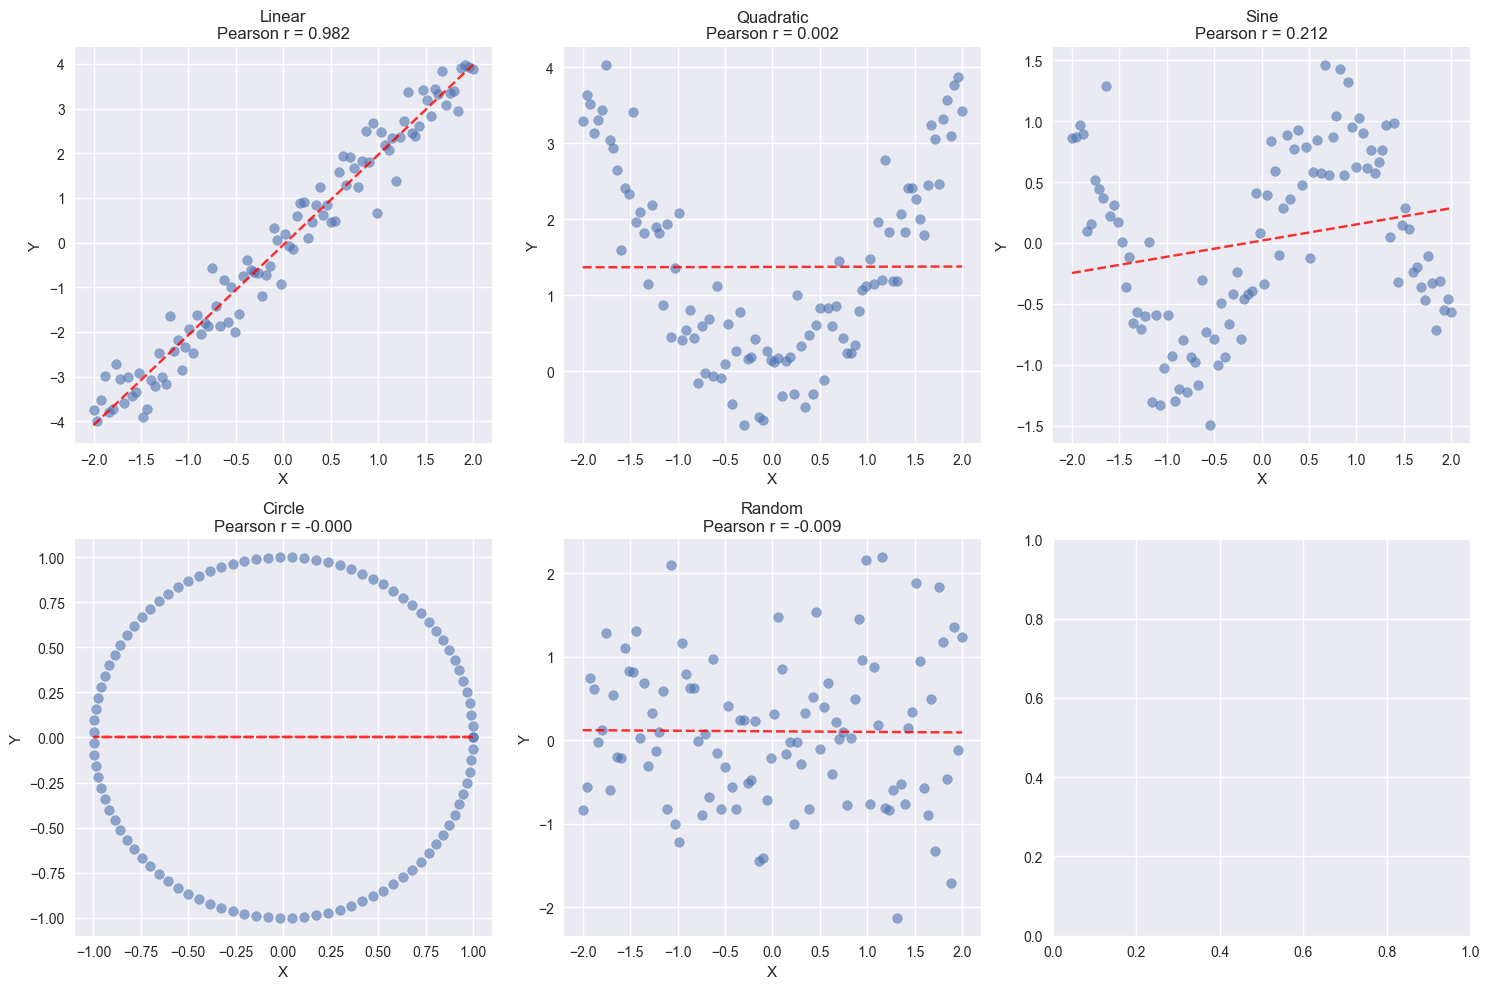

In [3]:
def visualize_pearson_examples():
    """Show when Pearson works well and when it fails"""
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.ravel()
    
    for i, (name, (x, y)) in enumerate(sample_data.items()):
        ax = axes[i]
        ax.scatter(x, y, alpha=0.6)
        
        # Calculate Pearson correlation
        r = pearson_correlation_from_scratch(x, y)
        
        # Add best fit line for visualization
        z = np.polyfit(x, y, 1)
        p = np.poly1d(z)
        ax.plot(x, p(x), "r--", alpha=0.8)
        
        ax.set_title(f'{name.capitalize()}\nPearson r = {r:.3f}')
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
    
    plt.tight_layout()
    plt.show()

visualize_pearson_examples()

**Properties**:
- Range: $r \in [-1, 1]$
- $r = 1$: Perfect positive linear relationship
- $r = -1$: Perfect negative linear relationship  
- $r = 0$: No linear relationship

### 1.2 Spearman Correlation: The Ranking Detective 🏆

**What it does**: Asks "Do these variables tend to increase and decrease together, even if not in a straight line?"

**Mathematical Definition**:
Spearman's rank correlation coefficient is the Pearson correlation applied to the ranks of the data:

$$\rho_s = \frac{\text{Cov}(R_X, R_Y)}{\sigma_{R_X} \sigma_{R_Y}}$$

Where $R_X$ and $R_Y$ are the ranks of X and Y respectively.

**Simplified Formula** (when no ties):
$$\rho_s = 1 - \frac{6\sum_{i=1}^{n} d_i^2}{n(n^2-1)}$$

Where $d_i = R_{X_i} - R_{Y_i}$ is the difference between ranks.

In [4]:
def spearman_correlation_from_scratch(x, y):
    """
    Implement Spearman correlation from scratch
    The magic: Convert to ranks first, then apply Pearson!
    """
    def rank_data(data):
        """Convert data to ranks (1 = smallest, n = largest)"""
        # Sort the data and get the original indices
        sorted_indices = np.argsort(data)
        ranks = np.empty_like(sorted_indices)
        
        # Assign ranks
        for i, original_index in enumerate(sorted_indices):
            ranks[original_index] = i + 1
            
        return ranks.astype(float)
    
    # Step 1: Convert both variables to ranks
    x_ranks = rank_data(x)
    y_ranks = rank_data(y)
    
    # Step 2: Apply Pearson correlation to the ranks
    spearman_corr = pearson_correlation_from_scratch(x_ranks, y_ranks)
    
    return spearman_corr

def demonstrate_rank_transformation():
    """Show how the ranking transformation works"""
    print("Rank Transformation Example:")
    print("="*40)
    
    # Create a simple example
    original = np.array([1, 3, 7, 12, 20])
    ranks = np.argsort(np.argsort(original)) + 1
    
    print("Original values:", original)
    print("Ranks:          ", ranks)
    print()
    
    # Show on exponential relationship
    x = np.array([1, 2, 3, 4, 5])
    y = np.array([2, 4, 8, 16, 32])  # Exponential!
    
    print("Exponential relationship example:")
    print("X values:", x)
    print("Y values:", y)
    print("X ranks: ", np.argsort(np.argsort(x)) + 1)
    print("Y ranks: ", np.argsort(np.argsort(y)) + 1)
    print()
    
    pearson_r = pearson_correlation_from_scratch(x, y)
    spearman_r = spearman_correlation_from_scratch(x, y)
    
    print(f"Pearson correlation:  {pearson_r:.3f}")
    print(f"Spearman correlation: {spearman_r:.3f}")
    print("Spearman catches the monotonic relationship perfectly!")

demonstrate_rank_transformation()

Rank Transformation Example:
Original values: [ 1  3  7 12 20]
Ranks:           [1 2 3 4 5]

Exponential relationship example:
X values: [1 2 3 4 5]
Y values: [ 2  4  8 16 32]
X ranks:  [1 2 3 4 5]
Y ranks:  [1 2 3 4 5]

Pearson correlation:  0.933
Spearman correlation: 1.000
Spearman catches the monotonic relationship perfectly!


**Why this is brilliant**:
- Works with curved relationships (as long as they're monotonic)
- Not fooled by outliers
- Handles ordinal data naturally

---

### 1.3 Kendall's Tau: The Pairwise Agreement Detective 🤝

**What it does**: Looks at every pair of points and asks "Do they agree on which one should be higher?"

**Mathematical Definition**:
Kendall's tau measures the ordinal association between two variables:

$$\tau = \frac{C - D}{\binom{n}{2}} = \frac{C - D}{\frac{n(n-1)}{2}}$$

Where:
- $C$ = number of concordant pairs
- $D$ = number of discordant pairs
- A pair $(x_i, y_i)$ and $(x_j, y_j)$ is:
  - **Concordant** if $(x_i - x_j)(y_i - y_j) > 0$
  - **Discordant** if $(x_i - x_j)(y_i - y_j) < 0$

**Alternative form**:
$$\tau = \frac{2}{n(n-1)} \sum_{i<j} \text{sign}(x_i - x_j) \cdot \text{sign}(y_i - y_j)$$

In [5]:
def kendall_tau_from_scratch(x, y):
    """
    Implement Kendall's Tau from scratch
    For every pair of points, check if they agree on ordering
    """
    n = len(x)
    concordant = 0  # Pairs that agree
    discordant = 0  # Pairs that disagree
    
    # Compare every pair of points
    for i in range(n):
        for j in range(i + 1, n):
            # Check if the ordering agrees
            x_diff = x[i] - x[j]
            y_diff = y[i] - y[j]
            
            if x_diff * y_diff > 0:  # Same sign = agreement
                concordant += 1
            elif x_diff * y_diff < 0:  # Different sign = disagreement
                discordant += 1
            # If one difference is 0, it's a tie (we ignore for simplicity)
    
    # Kendall's tau
    total_pairs = concordant + discordant
    if total_pairs == 0:
        return 0
    
    tau = (concordant - discordant) / total_pairs
    return tau

def demonstrate_kendall_logic():
    """Show how Kendall's tau works with a simple example"""
    print("\nKendall's Tau Logic:")
    print("="*30)
    
    # Simple example
    x = np.array([1, 2, 3, 4, 5])
    y = np.array([2, 1, 4, 3, 5])  # Some inversions
    
    print("X:", x)
    print("Y:", y)
    print()
    
    n = len(x)
    concordant = discordant = 0
    
    print("Pairwise comparisons:")
    for i in range(n):
        for j in range(i + 1, n):
            x_order = ">" if x[i] > x[j] else "<"
            y_order = ">" if y[i] > y[j] else "<"
            agreement = "✓" if x_order == y_order else "✗"
            
            if x[i] != x[j] and y[i] != y[j]:  # No ties
                if x_order == y_order:
                    concordant += 1
                else:
                    discordant += 1
                    
                print(f"({x[i]},{y[i]}) vs ({x[j]},{y[j]}): "
                      f"X order: {x_order}, Y order: {y_order} {agreement}")
    
    tau = kendall_tau_from_scratch(x, y)
    scipy_tau, _ = stats.kendalltau(x, y)
    
    print(f"\nConcordant pairs: {concordant}")
    print(f"Discordant pairs: {discordant}")
    print(f"Our Tau: {tau:.3f}")
    print(f"SciPy Tau: {scipy_tau:.3f}")

demonstrate_kendall_logic()


Kendall's Tau Logic:
X: [1 2 3 4 5]
Y: [2 1 4 3 5]

Pairwise comparisons:
(1,2) vs (2,1): X order: <, Y order: > ✗
(1,2) vs (3,4): X order: <, Y order: < ✓
(1,2) vs (4,3): X order: <, Y order: < ✓
(1,2) vs (5,5): X order: <, Y order: < ✓
(2,1) vs (3,4): X order: <, Y order: < ✓
(2,1) vs (4,3): X order: <, Y order: < ✓
(2,1) vs (5,5): X order: <, Y order: < ✓
(3,4) vs (4,3): X order: <, Y order: > ✗
(3,4) vs (5,5): X order: <, Y order: < ✓
(4,3) vs (5,5): X order: <, Y order: < ✓

Concordant pairs: 8
Discordant pairs: 2
Our Tau: 0.600
SciPy Tau: 0.600


**Properties**:
- Range: $\tau \in [-1, 1]$
- More robust to outliers than Pearson
- Computationally expensive: $O(n^2)$

Got it — let’s rewrite your section in a more **step-by-step, pedagogical way** so students can follow the intuition before diving into the compact equations. I’ll expand the explanations and keep them math-rigorous but accessible.

---

# 🧠 Part 2: The Information Theory Revolution

## 2.1 Mutual Information: The Shared Secrets Detective 🔍

### Step 1. The Core Question

Mutual Information (MI) answers:

> **“If I know X, how much uncertainty about Y disappears?”**

This is different from correlation, because MI detects *any kind of relationship* (linear or nonlinear).

---

### Step 2. The Formal Definition

We start with the joint probability distribution $p(x,y)$ and the marginals $p(x)$ and $p(y)$.

$$
I(X;Y) \;=\; \sum_{x \in \mathcal{X}} \sum_{y \in \mathcal{Y}} 
p(x,y) \; \log \frac{p(x,y)}{p(x)\,p(y)} .
$$

* $p(x,y)$: how often X and Y occur together
* $p(x)p(y)$: what we would expect if they were **independent**
* The log-ratio $\log \tfrac{p(x,y)}{p(x)p(y)}$: how “surprised” we are to see them together compared to independence
* The summation averages this surprise across all possible values of $X$ and $Y$.

If $X$ and $Y$ are independent, then $p(x,y)=p(x)p(y)$, the log-ratio is 0, and $I(X;Y)=0$.

---

### Step 3. Entropy Connection

We can re-express MI using **entropy**, the measure of uncertainty.

* Entropy of $X$:

  $$
  H(X) = -\sum_{x} p(x)\,\log p(x)
  $$

* Conditional entropy of $X$ given $Y$:

  $$
  H(X|Y) = -\sum_{x,y} p(x,y)\,\log p(x|y)
  $$

* Joint entropy:

  $$
  H(X,Y) = -\sum_{x,y} p(x,y)\,\log p(x,y)
  $$

Now, we can write Mutual Information in three equivalent ways:

$$
I(X;Y) = H(X) - H(X|Y) = H(Y) - H(Y|X) = H(X) + H(Y) - H(X,Y).
$$

**Intuition**:

* $H(X)$: uncertainty in $X$ alone
* $H(X|Y)$: uncertainty left about $X$ once $Y$ is known
* Their difference = how much uncertainty about $X$ was *removed* thanks to $Y$.

---

### Step 4. Continuous Variables

For continuous random variables, sums become integrals and probabilities become probability densities:

$$
I(X;Y) \;=\; \int \int p(x,y)\, \log \frac{p(x,y)}{p(x)p(y)} \, dx \, dy .
$$

Here we use **differential entropy**, but the interpretation remains identical.

---

### Step 5. Properties

* **Range**: $I(X;Y) \geq 0$, with equality iff $X$ and $Y$ are independent.
* **Units**: measured in *bits* if the log is base 2, or *nats* if the log is base $e$.
* **Symmetry**: $I(X;Y) = I(Y;X)$.
* **Power**: detects nonlinear relationships missed by correlation.
* **Cost**: needs estimation of joint distributions, which can be expensive for large $n$ or continuous domains.

---

### 📝 Example (Pedagogical Python)

```python
import numpy as np
from sklearn.metrics import mutual_info_score

# Suppose X and Y are categorical
X = np.random.choice([0,1], size=1000, p=[0.5,0.5])
Y = X ^ np.random.choice([0,1], size=1000, p=[0.9,0.1])  # noisy copy of X

mi = mutual_info_score(X, Y)
print("Estimated MI:", mi)
```

This measures “how much knowing `X` reduces the uncertainty in `Y`”.

In [6]:
def mutual_information_from_scratch(x, y, bins=10):
    """
    Implement Mutual Information using histogram method
    MI(X,Y) = H(X) + H(Y) - H(X,Y)
    """
    
    def entropy(data, bins):
        """Calculate entropy of a variable"""
        hist, _ = np.histogram(data, bins=bins)
        # Remove zeros to avoid log(0)
        hist = hist[hist > 0]
        # Convert to probabilities
        probs = hist / hist.sum()
        # Calculate entropy: -sum(p * log(p))
        return -np.sum(probs * np.log2(probs))
    
    def joint_entropy(x, y, bins):
        """Calculate joint entropy H(X,Y)"""
        # Create 2D histogram
        hist, _, _ = np.histogram2d(x, y, bins=bins)
        # Remove zeros
        hist = hist[hist > 0]
        # Convert to probabilities
        probs = hist / hist.sum()
        # Calculate joint entropy
        return -np.sum(probs * np.log2(probs))
    
    # Calculate individual entropies
    h_x = entropy(x, bins)
    h_y = entropy(y, bins)
    
    # Calculate joint entropy
    h_xy = joint_entropy(x, y, bins)
    
    # Mutual Information = H(X) + H(Y) - H(X,Y)
    mi = h_x + h_y - h_xy
    
    return mi

def adaptive_mutual_information(x, y):
    """
    Smart MI that tries different bin sizes and takes median
    """
    # Quick check: if variables are nearly uncorrelated, skip expensive MI
    spearman_corr, _ = stats.spearmanr(x, y)
    if abs(spearman_corr) < 0.1:
        return 0.0  # Probably not worth the computation
    
    # Try different bin sizes
    bin_sizes = [3, 5, 10]
    mi_estimates = []
    
    for bins in bin_sizes:
        try:
            mi = mutual_information_from_scratch(x, y, bins)
            mi_estimates.append(mi)
        except:
            continue
    
    if len(mi_estimates) == 0:
        return 0.0
    
    # Return median estimate (robust to binning choice)
    return np.median(mi_estimates)

def demonstrate_mutual_information():
    """Show MI in action on different relationship types"""
    print("\nMutual Information Analysis:")
    print("="*40)
    
    for name, (x, y) in sample_data.items():
        # Our implementation
        mi = adaptive_mutual_information(x, y)
        
        # For comparison, let's also show Pearson
        pearson_r = pearson_correlation_from_scratch(x, y)
        
        print(f"{name:>10}: MI={mi:.3f}, Pearson={pearson_r:.3f}")
    
    print("\nNotice: MI can detect nonlinear relationships that Pearson misses!")

demonstrate_mutual_information()


Mutual Information Analysis:
    linear: MI=1.557, Pearson=0.982
 quadratic: MI=0.000, Pearson=0.002
      sine: MI=0.603, Pearson=0.212
    circle: MI=0.000, Pearson=-0.000
    random: MI=0.000, Pearson=-0.009

Notice: MI can detect nonlinear relationships that Pearson misses!


**Properties**:
- Range: $I(X;Y) \geq 0$
- $I(X;Y) = 0$ if and only if X and Y are independent
- Scale-invariant
- Detects any type of dependence (not just linear)

---

### 2.2 HSIC: The Kernel Similarity Detective 🎭

**The Revolutionary Idea**: Instead of looking at variables directly, transform them into "similarity spaces" and then measure dependence.

**Mathematical Definition**:
The Hilbert-Schmidt Independence Criterion (HSIC) measures dependence using kernel methods:

$$\text{HSIC}(X,Y) = \text{tr}(\mathbf{KHLH})$$

Where:
- $\mathbf{K}_{ij} = k(x_i, x_j)$ is the kernel matrix for X
- $\mathbf{L}_{ij} = l(y_i, y_j)$ is the kernel matrix for Y  
- $\mathbf{H} = \mathbf{I} - \frac{1}{n}\mathbf{1}\mathbf{1}^T$ is the centering matrix

**Alternative Formula**:
$$\text{HSIC}(X,Y) = \frac{1}{(n-1)^2} \text{tr}(\tilde{\mathbf{K}}\tilde{\mathbf{L}})$$

Where $\tilde{\mathbf{K}} = \mathbf{HKH}$ and $\tilde{\mathbf{L}} = \mathbf{HLH}$ are centered kernel matrices.

**Population HSIC**:
$$\text{HSIC}(P_{XY}, \mathcal{F}, \mathcal{G}) = \mathbb{E}_{XX'YY'}[k(X,X')l(Y,Y')] + \mathbb{E}_{XX'}[k(X,X')]\mathbb{E}_{YY'}[l(Y,Y')] - 2\mathbb{E}_{XY}[\mathbb{E}_{X'}[k(X,X')]\mathbb{E}_{Y'}[l(Y,Y')]]$$

In [12]:
def rbf_kernel(x, y, sigma=None):
    """
    Radial Basis Function (Gaussian) kernel
    k(x,y) = exp(-||x-y||²/(2σ²))
    """
    if sigma is None:
        # Median heuristic: use median distance as bandwidth
        distances = pdist(x.reshape(-1, 1))
        sigma = np.median(distances)
        if sigma == 0:
            sigma = 1.0
        
    # Calculate pairwise distances correctly
    x_expanded = x.reshape(-1, 1)
    # Create distance matrix: ||x_i - x_j||²
    distances_sq = np.sum((x_expanded[:, None] - x_expanded[None, :])**2, axis=2)
    
    # Apply Gaussian kernel
    kernel_matrix = np.exp(-distances_sq / (2 * sigma**2))
    return kernel_matrix

def center_kernel_matrix(K):
    """
    Center the kernel matrix (remove mean similarities)
    H @ K @ H where H = I - (1/n) * ones_matrix
    """
    n = K.shape[0]
    # Create centering matrix H = I - (1/n) * ones_matrix
    ones = np.ones((n, n)) / n
    H = np.eye(n) - ones
    
    # Center the kernel: H @ K @ H
    K_centered = H @ K @ H
    return K_centered

def hsic_from_scratch(x, y, sigma_x=None, sigma_y=None):
    """
    Implement HSIC (Hilbert-Schmidt Independence Criterion)
    Measures dependence using kernel similarities
    """
    n = len(x)
    
    # Create kernel matrices
    K_x = rbf_kernel(x, x, sigma_x)
    K_y = rbf_kernel(y, y, sigma_y)
    
    # Center the kernel matrices
    K_x_centered = center_kernel_matrix(K_x)
    K_y_centered = center_kernel_matrix(K_y)
    
    # HSIC = trace(K_x_centered @ K_y_centered) / (n-1)^2
    hsic_value = np.trace(K_x_centered @ K_y_centered) / ((n-1)**2)
    
    return hsic_value

def demonstrate_hsic():
    """Show HSIC detecting complex relationships"""
    print("\nHSIC Analysis:")
    print("="*30)
    
    for name, (x, y) in sample_data.items():
        # Calculate HSIC
        hsic_val = hsic_from_scratch(x, y)
        
        # Compare with other methods
        pearson_r = pearson_correlation_from_scratch(x, y)
        mi = adaptive_mutual_information(x, y)
        
        print(f"{name:>10}: HSIC={hsic_val:.4f}, MI={mi:.3f}, Pearson={pearson_r:.3f}")

demonstrate_hsic()


HSIC Analysis:
    linear: HSIC=0.0964, MI=1.557, Pearson=0.982
 quadratic: HSIC=0.0282, MI=0.000, Pearson=0.002
      sine: HSIC=0.0163, MI=0.603, Pearson=0.212
    circle: HSIC=0.0078, MI=0.000, Pearson=-0.000
    random: HSIC=0.0028, MI=0.000, Pearson=-0.009


**Properties**:
- Range: $\text{HSIC}(X,Y) \geq 0$
- $\text{HSIC}(X,Y) = 0$ if and only if X and Y are independent (under mild conditions)
- Can detect any type of dependence
- Based on reproducing kernel Hilbert space theory

---

## 🚀 Part 3: Modern Nonlinear Methods

### 3.1 Distance Correlation: The Geometric Detective 📐

**Core Insight**: Instead of looking at linear relationships, look at all distances between points.

**Mathematical Definition**:
Distance correlation is based on distance covariance. For random variables X and Y:

$$\text{dCov}^2(X,Y) = \int_{\mathbb{R}^2} |\phi_{X,Y}(t,s) - \phi_X(t)\phi_Y(s)|^2 w(t,s) \, dt \, ds$$

Where $\phi_{X,Y}$, $\phi_X$, $\phi_Y$ are characteristic functions and $w(t,s) = (c_d c_e |t|_d^{1+d} |s|_e^{1+e})^{-1}$ is a weight function.

**Sample Distance Correlation**:
$$\text{dCorr}(X,Y) = \frac{\text{dCov}(X,Y)}{\sqrt{\text{dVar}(X)\text{dVar}(Y)}}$$

**Computational Formula**:
For distance matrices $\mathbf{A}$ and $\mathbf{B}$ (doubly centered distance matrices):

$$\text{dCov}^2_n(X,Y) = \frac{1}{n^2} \sum_{i,j=1}^{n} A_{ij} B_{ij}$$

$$\text{dVar}^2_n(X) = \frac{1}{n^2} \sum_{i,j=1}^{n} A_{ij}^2$$

In [13]:
def distance_correlation_from_scratch(x, y):
    """
    Implement distance correlation
    Measures dependence through geometric relationships
    """
    def distance_matrix(data):
        """Calculate pairwise Euclidean distances"""
        data = data.reshape(-1, 1)
        n = len(data)
        distances = np.zeros((n, n))
        
        for i in range(n):
            for j in range(n):
                distances[i, j] = abs(data[i] - data[j])
        return distances
    
    def doubly_center_distance_matrix(D):
        """Apply double centering to distance matrix"""
        n = D.shape[0]
        
        # Row means
        row_means = np.mean(D, axis=1, keepdims=True)
        # Column means  
        col_means = np.mean(D, axis=0, keepdims=True)
        # Grand mean
        grand_mean = np.mean(D)
        
        # Double centering: A_ij = D_ij - D_i• - D_•j + D_••
        A = D - row_means - col_means + grand_mean
        return A
    
    # Calculate distance matrices
    D_x = distance_matrix(x)
    D_y = distance_matrix(y)
    
    # Apply double centering
    A = doubly_center_distance_matrix(D_x)
    B = doubly_center_distance_matrix(D_y)
    
    # Calculate distance covariance
    n = len(x)
    dcov_xy = np.sqrt(np.sum(A * B) / (n * n))
    
    # Calculate distance variances
    dvar_x = np.sqrt(np.sum(A * A) / (n * n))
    dvar_y = np.sqrt(np.sum(B * B) / (n * n))
    
    # Distance correlation
    if dvar_x > 0 and dvar_y > 0:
        dcorr = dcov_xy / np.sqrt(dvar_x * dvar_y)
    else:
        dcorr = 0
    
    return dcorr

def demonstrate_distance_correlation():
    """Show distance correlation on various relationships"""
    print("\nDistance Correlation Analysis:")
    print("="*40)
    
    for name, (x, y) in sample_data.items():
        dcorr = distance_correlation_from_scratch(x, y)
        pearson_r = pearson_correlation_from_scratch(x, y)
        
        print(f"{name:>10}: dCorr={dcorr:.3f}, Pearson={pearson_r:.3f}")
    
    print("\nDistance correlation detects geometric relationships!")

demonstrate_distance_correlation()


Distance Correlation Analysis:
    linear: dCorr=0.980, Pearson=0.982
 quadratic: dCorr=0.459, Pearson=0.002
      sine: dCorr=0.417, Pearson=0.212
    circle: dCorr=0.200, Pearson=-0.000
    random: dCorr=0.175, Pearson=-0.009

Distance correlation detects geometric relationships!


/tmp/ipykernel_353108/1284693291.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  distances[i, j] = abs(data[i] - data[j])


**Properties**:
- Range: $\text{dCorr}(X,Y) \in [0, 1]$
- $\text{dCorr}(X,Y) = 0$ if and only if X and Y are independent
- Detects nonlinear relationships
- Based on energy statistics

### 3.2 Chatterjee Correlation: The Nearest Neighbor Detective 👥

**The Elegant Idea**: Look at how "orderly" Y is when you sort by X.

**Mathematical Definition**:
For a sample $(X_1, Y_1), \ldots, (X_n, Y_n)$, let $(X_{(1)}, Y_{(1)}), \ldots, (X_{(n)}, Y_{(n)})$ be the data sorted by X values. Let $r_i$ be the rank of $Y_{(i)}$ among $Y_{(1)}, \ldots, Y_{(n)}$.

Chatterjee's correlation coefficient is:

$$\xi_n(X,Y) = 1 - \frac{3\sum_{i=1}^{n-1} |r_{i+1} - r_i|}{n^2 - 1}$$

**Alternative Formulation**:
$$\xi_n(X,Y) = \frac{2}{n^2-1} \sum_{i=1}^{n-1} (n-i) \cdot \mathbf{1}_{Y_{(i)} \leq Y_{(i+1)}} - \frac{n-1}{n+1}$$

**Asymptotic Properties**:
- $\xi_n(X,Y) \to \xi(X,Y)$ as $n \to \infty$
- $\xi(X,Y) = 0$ if and only if Y is independent of X
- $\xi(X,Y) = 1$ if Y is a measurable function of X

In [14]:
def chatterjee_correlation_from_scratch(x, y):
    """
    Implement Chatterjee's rank correlation
    Measures how much Y's ranks jump around when sorted by X
    """
    n = len(x)
    
    # Sort by X values, keep track of Y values
    sorted_indices = np.argsort(x)
    y_sorted_by_x = y[sorted_indices]
    
    # Get ranks of Y values in the X-sorted order
    y_ranks = np.argsort(np.argsort(y_sorted_by_x)) + 1
    
    # Calculate how much the ranks jump around
    rank_differences = np.abs(np.diff(y_ranks))
    total_variation = np.sum(rank_differences)
    
    # Chatterjee correlation
    xi = 1 - (3 * total_variation) / (n**2 - 1)
    
    return max(0, xi)  # Chatterjee correlation is non-negative

def demonstrate_chatterjee():
    """Show Chatterjee correlation with visual example"""
    print("\nChatterjee Correlation Analysis:")
    print("="*40)
    
    # Create a clear example
    x_example = np.array([1, 2, 3, 4, 5])
    y_smooth = np.array([1, 2, 3, 4, 5])    # Smooth progression
    y_jumpy = np.array([3, 1, 5, 2, 4])     # Jumpy progression
    
    print("Example to understand Chatterjee:")
    print("X (sorted):", x_example)
    print("Y smooth:  ", y_smooth, "-> Chatterjee =", 
          f"{chatterjee_correlation_from_scratch(x_example, y_smooth):.3f}")
    print("Y jumpy:   ", y_jumpy, "-> Chatterjee =",
          f"{chatterjee_correlation_from_scratch(x_example, y_jumpy):.3f}")
    print()
    
    # Test on our datasets
    for name, (x, y) in sample_data.items():
        chatterjee_corr = chatterjee_correlation_from_scratch(x, y)
        pearson_r = pearson_correlation_from_scratch(x, y)
        
        print(f"{name:>10}: Chatterjee={chatterjee_corr:.3f}, Pearson={pearson_r:.3f}")

demonstrate_chatterjee()


Chatterjee Correlation Analysis:
Example to understand Chatterjee:
X (sorted): [1 2 3 4 5]
Y smooth:   [1 2 3 4 5] -> Chatterjee = 0.500
Y jumpy:    [3 1 5 2 4] -> Chatterjee = 0.000

    linear: Chatterjee=0.796, Pearson=0.982
 quadratic: Chatterjee=0.579, Pearson=0.002
      sine: Chatterjee=0.553, Pearson=0.212
    circle: Chatterjee=0.000, Pearson=-0.000
    random: Chatterjee=0.061, Pearson=-0.009


**Properties**:
- Range: $\xi_n(X,Y) \in [0, 1]$
- Asymmetric: $\xi(X,Y) \neq \xi(Y,X)$ in general
- $\xi_n(X,Y) = 0$ implies independence of Y from X
- Consistent estimator of population Chatterjee correlation

---

## 🎨 Part 4: The Art of Combining Methods

### 4.1 Why an Ensemble Approach?

**The Orchestra Analogy**: Each correlation method is like a different musical instrument:
- **Pearson**: Piano (good for melody/linear patterns)
- **Spearman**: Violin (catches the smooth curves)
- **MI**: Drums (detects rhythm/periodic patterns)
- **HSIC**: Full orchestra (catches everything but needs more resources)

**The Ensemble**: Average them all to get the "full sound"

$$\rho_{\text{ensemble}} = \frac{1}{M} \sum_{m=1}^{M} |\rho_m|$$

### 4.2 Smart Performance Scaling

The code adapts to your data size like a smart chef adapting recipes:

**Small data (< 1,000 points)**: "Full gourmet meal"
- Use all methods
- High precision, don't worry about time

**Medium data (1,000-5,000 points)**: "Good restaurant meal"  
- Skip the expensive methods (Kendall)
- Keep the informative ones

**Large data (> 5,000 points)**: "Fast food done right"
- Focus on scalable methods
- Use smart subsampling

---

## 🎓 Part 5: Practical Wisdom for Students

### 5.1 When to Use Which Method?

**Decision Tree**:
```
Is your relationship likely linear?
├─ YES: Start with Pearson
└─ NO: ↓

Do you have outliers?
├─ YES: Use Spearman or Robust Pearson
└─ NO: ↓

Do you suspect nonlinear patterns?
├─ YES: Use MI or HSIC
└─ UNSURE: Use the ensemble!
```

### 5.2 Interpretation Guidelines

**Strength Interpretation** (rule of thumb):
- **0.0-0.1**: "Basically random"
- **0.1-0.3**: "Weak signal" 
- **0.3-0.5**: "Noticeable pattern"
- **0.5-0.7**: "Strong relationship"
- **0.7-0.9**: "Very predictable"
- **0.9-1.0**: "Almost deterministic"

### 5.3 Common Student Pitfalls

**❌ "Correlation = Causation"**
- **Reality**: All these methods detect association, not causation
- **Remember**: Ice cream sales correlate with drowning deaths (both increase in summer!)

**❌ "Higher correlation is always better"**
- **Reality**: Sometimes you want to find variables that are independent
- **Example**: In diversified investing, you want uncorrelated assets

**❌ "One method fits all"**
- **Reality**: Different relationships need different detectors
- **Solution**: Use multiple methods and understand what each tells you

### 5.4 Hands-on Understanding

**Exercise 1**: Generate these datasets and see what each method gives:

In [ ]:
# Linear relationship
x = np.linspace(0, 10, 100)
y = 2*x + noise

# Quadratic relationship  
y = x**2 + noise

# Sine wave relationship
y = np.sin(x) + noise

# Circle relationship
x = np.cos(theta)
y = np.sin(theta)

**Prediction**: Which methods will be high/low for each?

**Exercise 2**: Create "correlation method profiles" for different scenarios:
- Which method would best detect a stock price following weather patterns?
- How would you detect if student study methods affect performance nonlinearly?

---

## 🔬 Part 6: The Deep Dive - Technical Implementation

### 6.1 Why Subsampling Works

**The Statistical Insight**: Most correlation patterns are visible even in representative samples.

**Smart Subsampling Strategy**:
1. **Use PCA**: Find the main direction of variation
2. **Stratify**: Take samples from different regions along this direction
3. **Preserve structure**: Don't just take random points

**Analogy**: Like tasting soup - you don't need to drink the whole pot, but you should stir first and taste from different spots!

### 6.2 The Parameter Tuning Philosophy

**Mutual Information Bins**: 
- **Too few bins**: Miss fine details (like looking at the world through thick glasses)
- **Too many bins**: Get fooled by noise (like seeing patterns in static)
- **Solution**: Try multiple bin counts and take the median

**HSIC Kernel Width**:
- **Too narrow**: Only sees identical points as similar
- **Too wide**: Everything looks similar
- **Median heuristic**: Use the median distance between points (adapts to data scale)

---

## 🎯 Conclusion: Becoming a Correlation Detective

Understanding these methods is like having a toolbox for data relationships:

1. **Start simple**: Always look at Pearson and Spearman first
2. **Think about your data**: What kind of relationships do you expect?
3. **Use multiple lenses**: Each method shows you something different
4. **Validate findings**: Don't trust a single method for important decisions
5. **Understand limitations**: Every method has blind spots

**The Ultimate Goal**: Develop intuition for which relationships each method can and cannot detect. Like a good detective, you need multiple tools and the wisdom to know when to use each one.

**Remember**: The goal isn't to memorize formulas - it's to understand what each method is really asking about your data and when that question is the right one to ask!

---

## 📖 Further Learning

**Next Steps for Curious Students**:
1. Implement these methods from scratch on simple datasets
2. Create visualizations showing when each method succeeds/fails
3. Explore kernel methods and information theory in more depth
4. Study causal inference methods (the next level beyond correlation)

**Key Insight**: Correlation analysis is often the first step in understanding your data, but it's rarely the last. Use these methods to guide your exploration, not to make final conclusions!

🔍 CORRELATION METHODS FROM SCRATCH - EDUCATIONAL DEMO

1. Pearson Correlation - The Straight Line Detective
--------------------------------------------------
Shows: How well do points follow a straight line?
Best for: Linear relationships
Fails on: Non-linear patterns, even if perfectly predictable


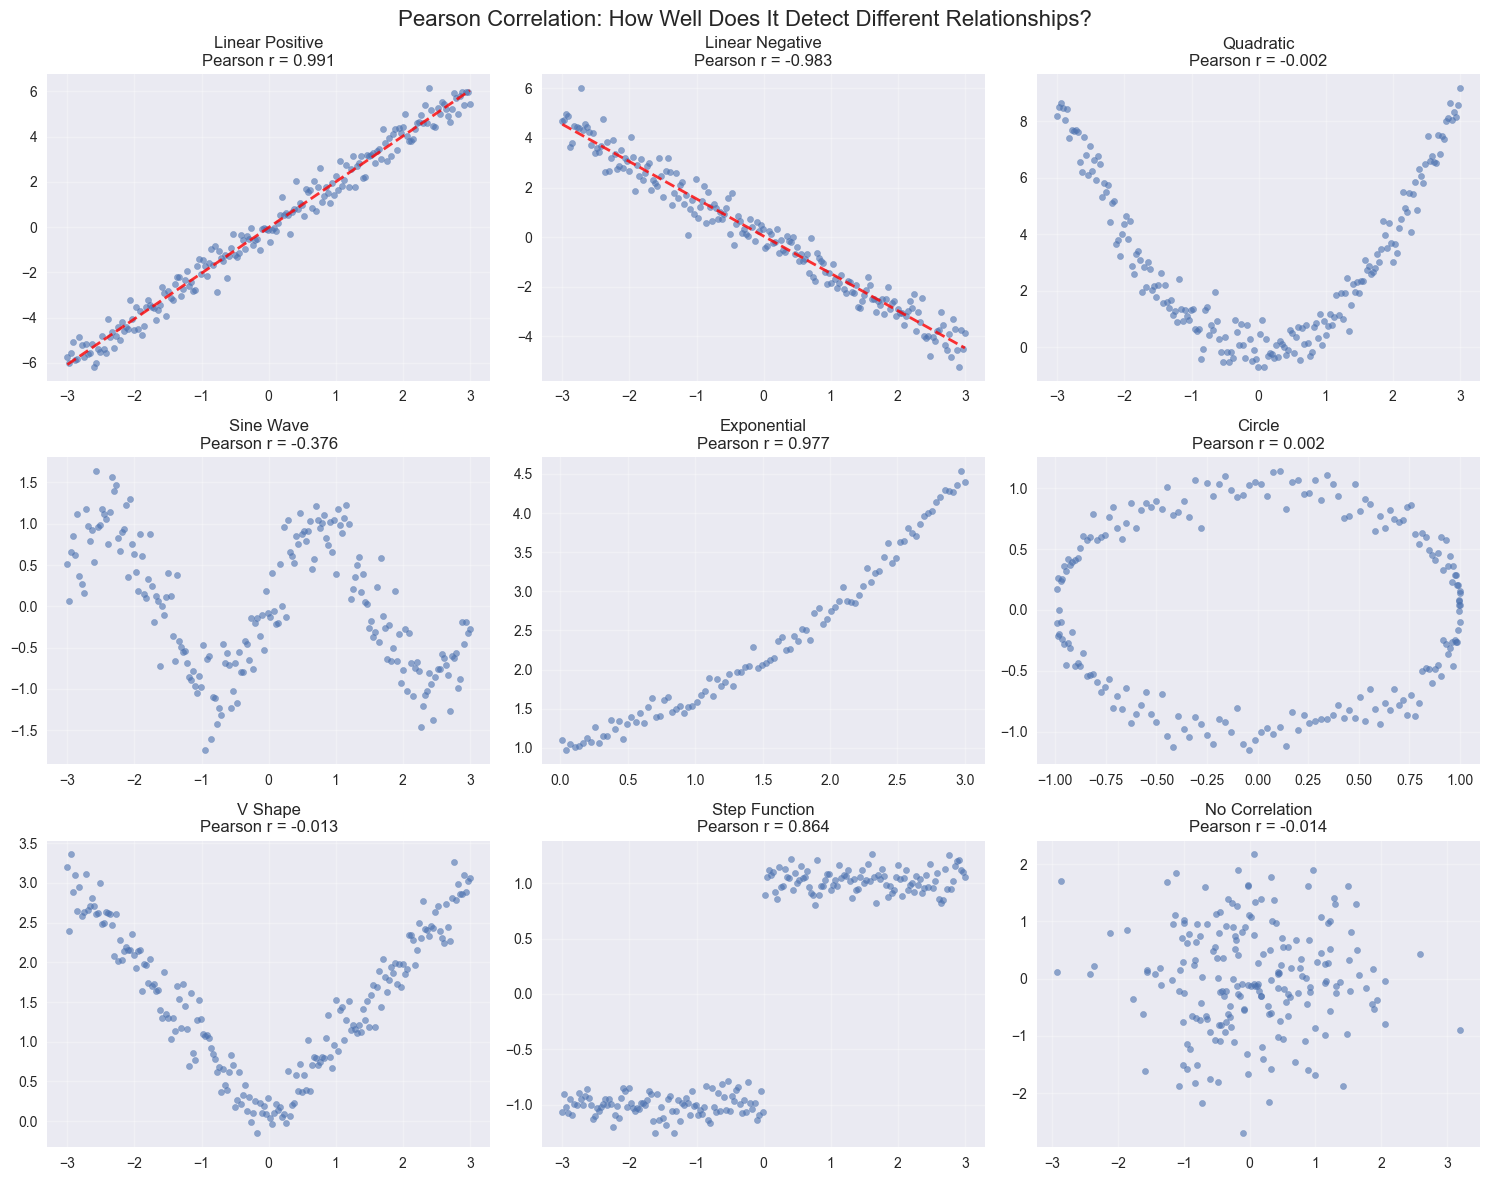


2. Spearman Correlation - The Ranking Detective
--------------------------------------------------
Shows: Do variables increase/decrease together (monotonic)?
Best for: Any monotonic relationship (curved but consistent direction)
Magic: Converts to ranks first, then applies Pearson


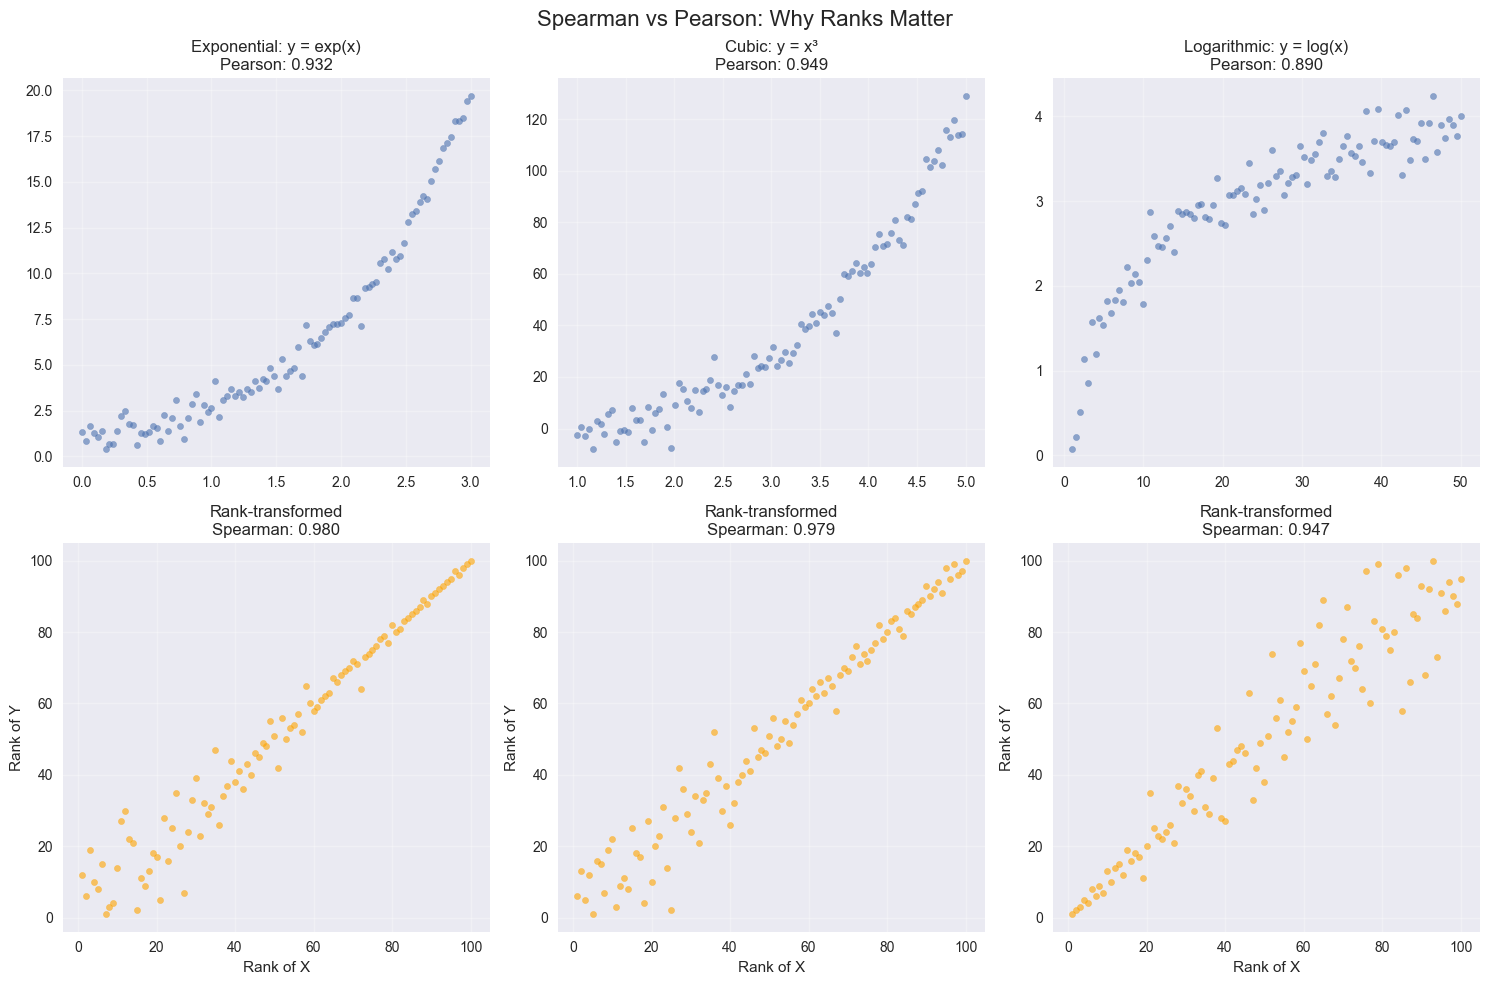


3. Mutual Information - The Information Detective
--------------------------------------------------
Shows: How much information does X give about Y?
Best for: Any relationship where knowing X helps predict Y
Strength: Detects complex non-linear patterns


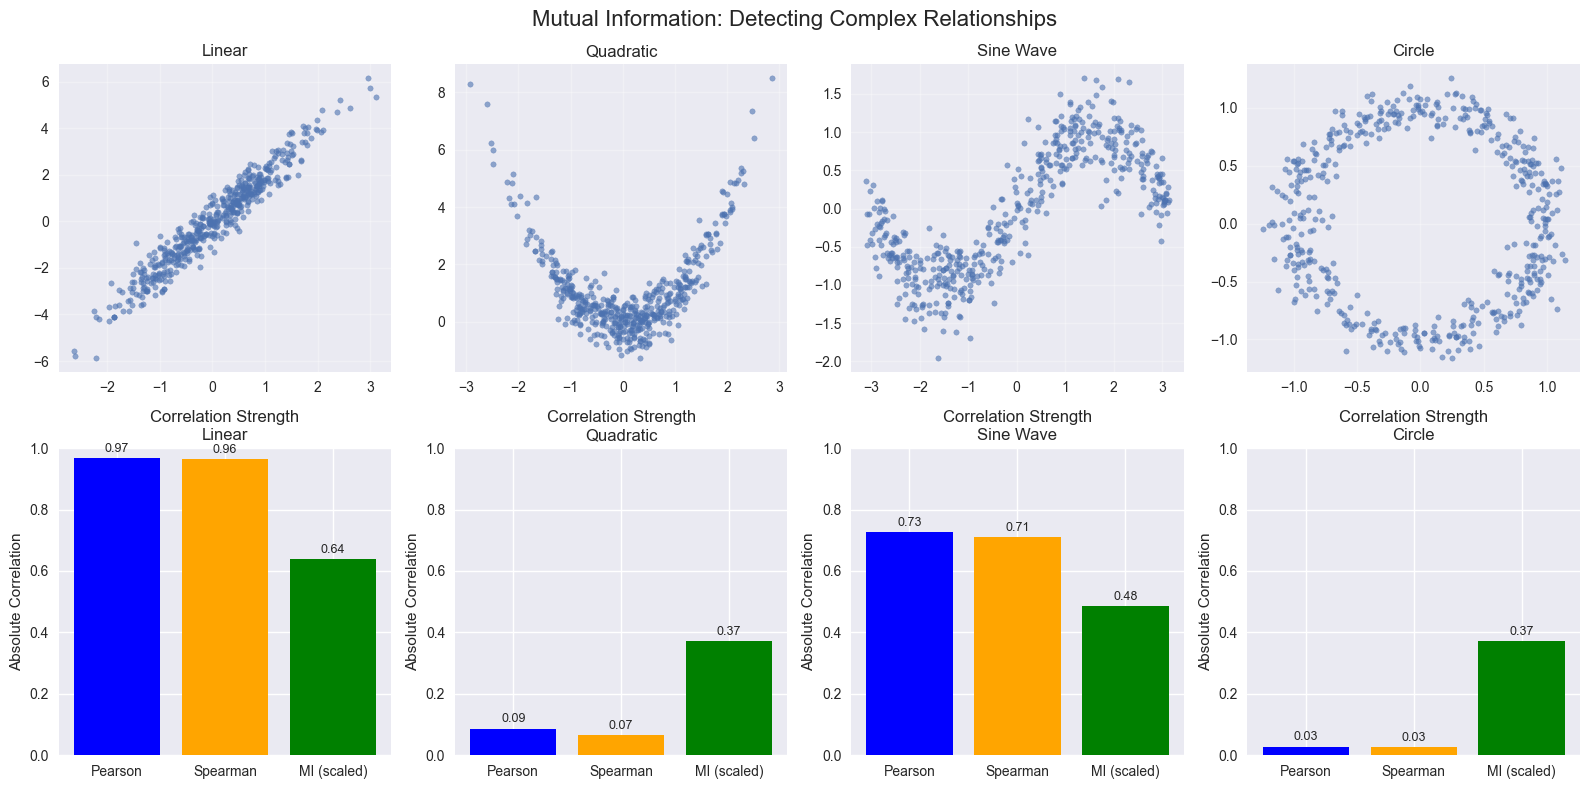


4. Distance Correlation - The Geometric Detective
--------------------------------------------------
Shows: Are the geometric patterns related?
Best for: Any functional relationship (including geometric)
Unique: Based on distances, not values


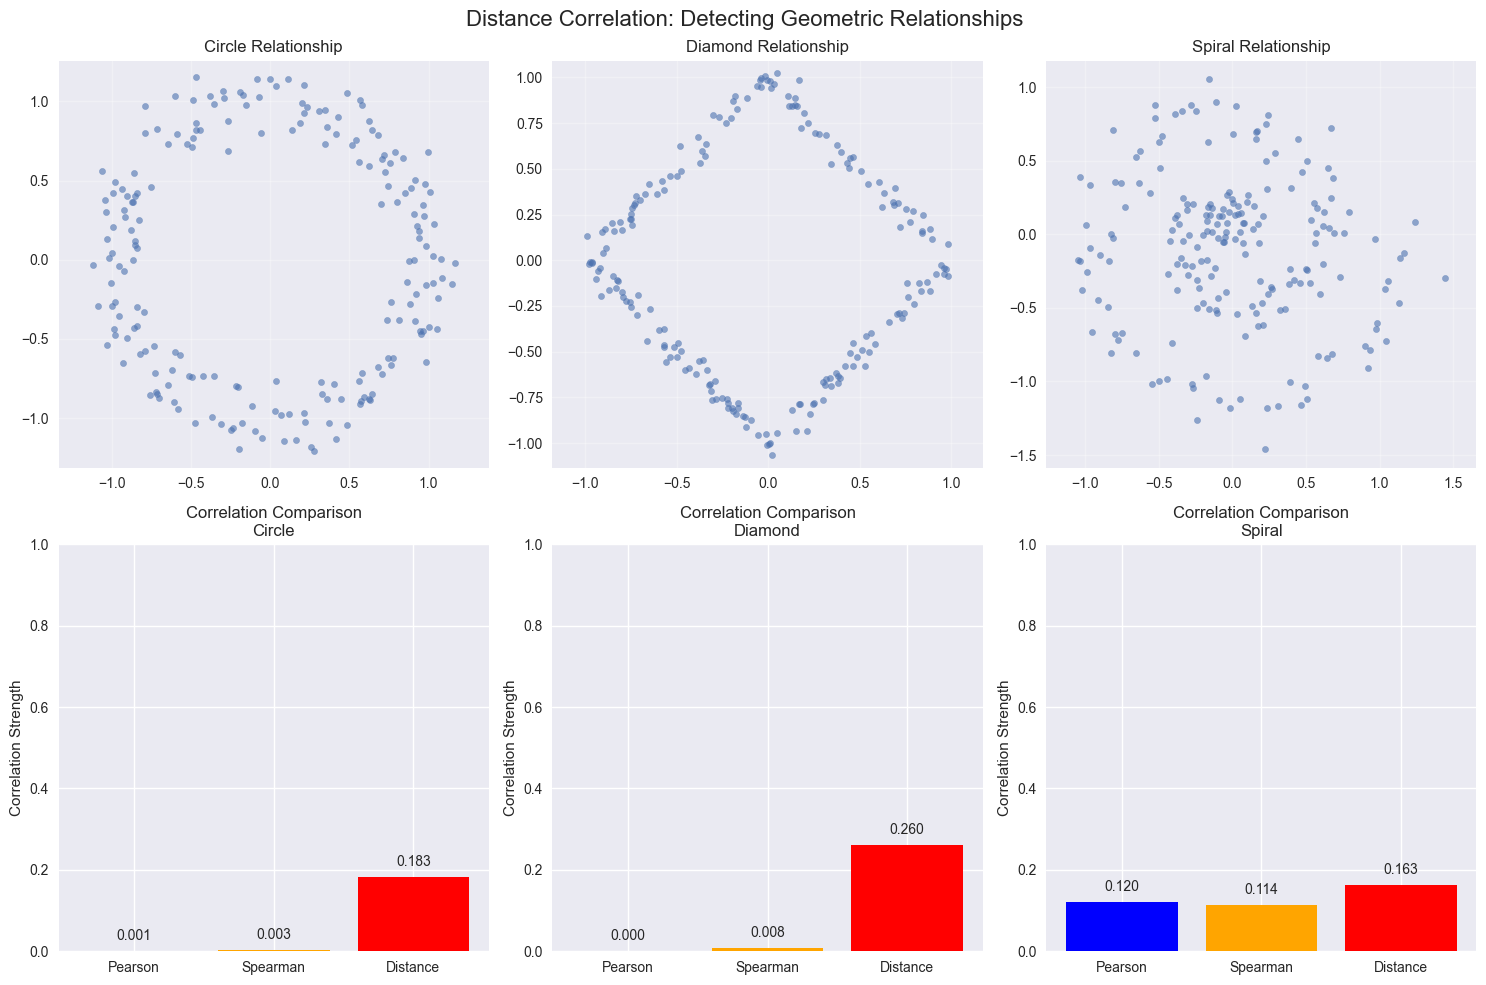


5. HSIC - The Kernel Similarity Detective
--------------------------------------------------
Shows: Do similarity patterns align between variables?
Best for: Most general dependence detection
Magic: Uses kernel functions to measure similarity


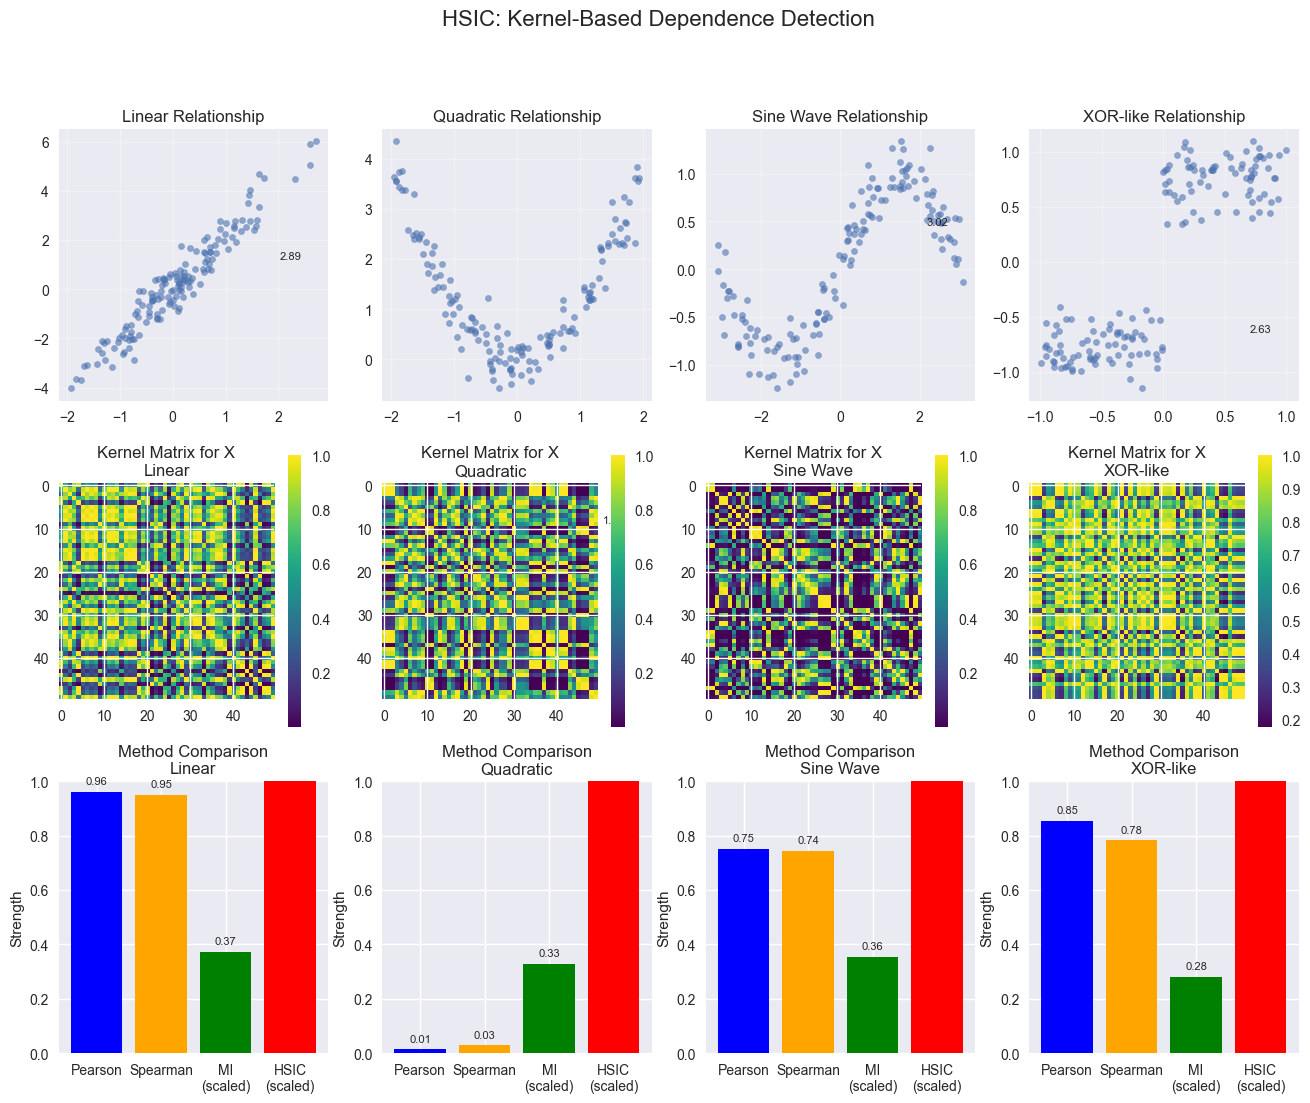


6. Comprehensive Comparison
--------------------------------------------------
Compare all methods across different relationship types


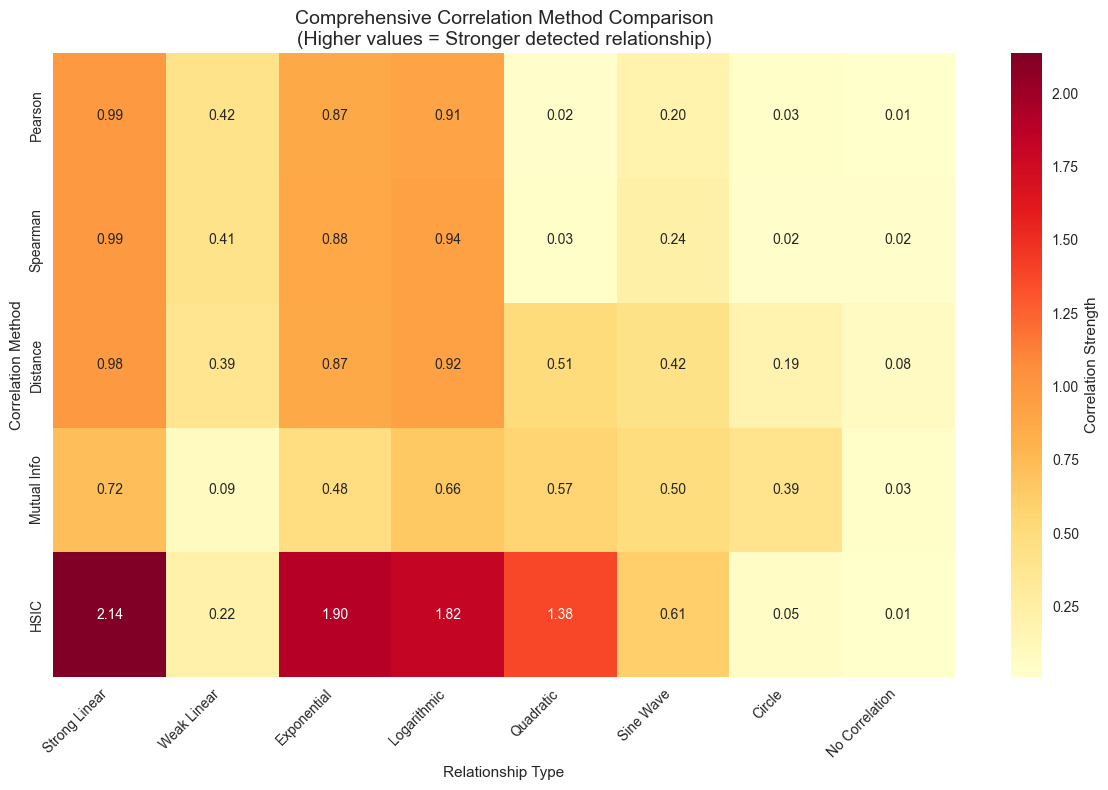

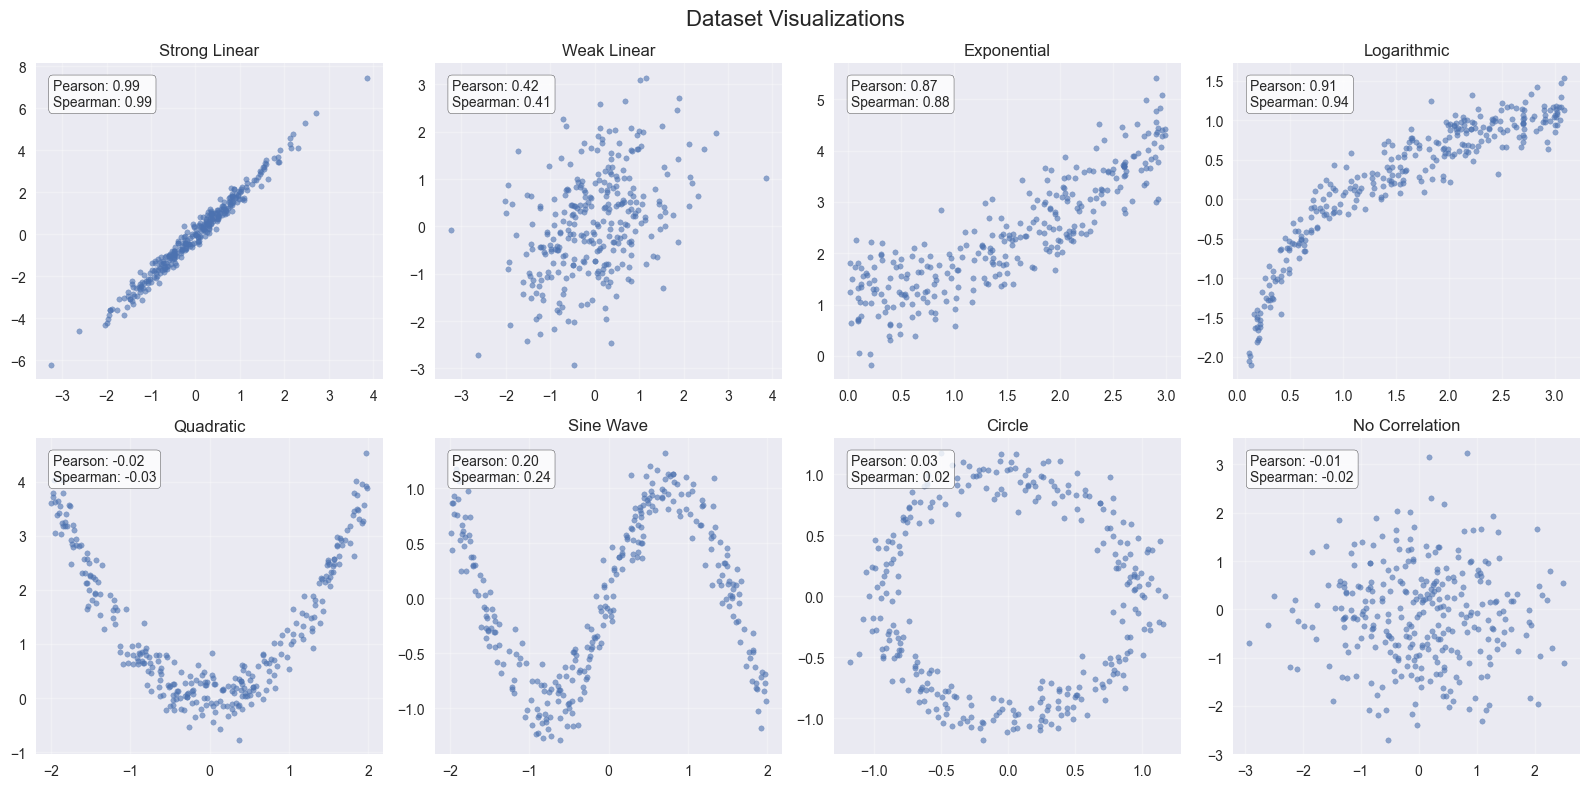


🎓 EDUCATIONAL TAKEAWAYS:
✓ Pearson: Fast, interpretable, but only sees straight lines
✓ Spearman: Robust, catches curves, but must be monotonic
✓ MI: Powerful, catches complex patterns, but harder to interpret
✓ Distance: Very general, but computationally expensive
✓ HSIC: Most powerful, but requires parameter tuning

🚀 Pro tip: Use multiple methods and compare results!

🎨 CREATE YOUR OWN RELATIONSHIP


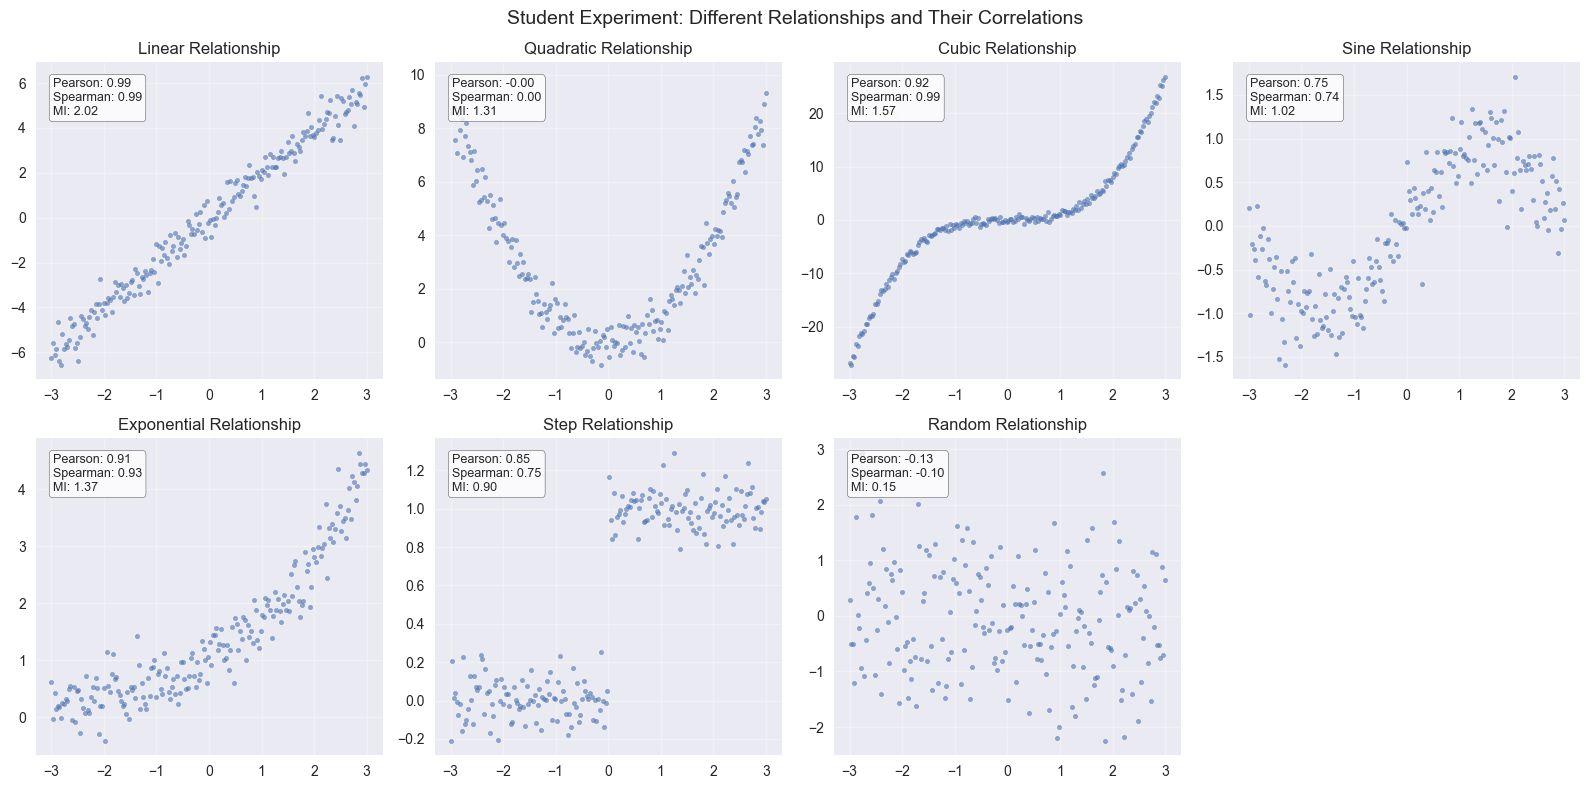


📊 CORRELATION STRENGTH INTERPRETATION GUIDE


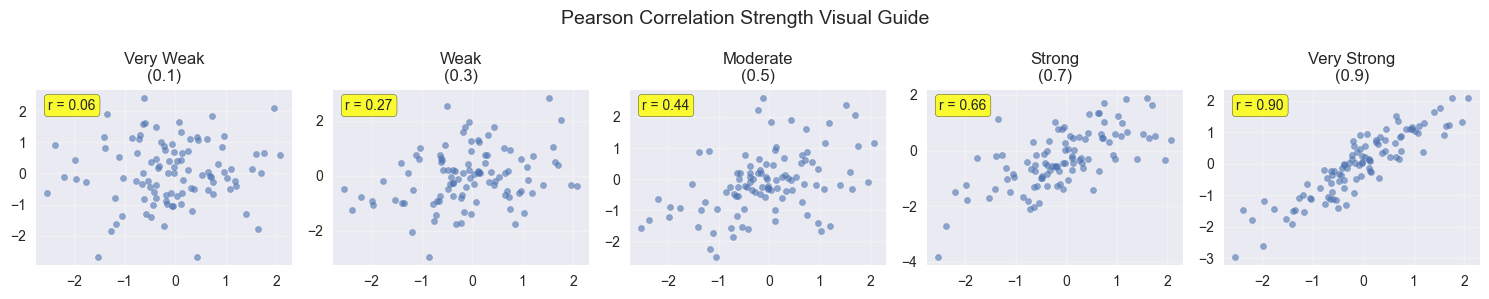


📋 INTERPRETATION TABLE:
------------------------------
0.0 - 0.1: Negligible
0.1 - 0.3: Weak
0.3 - 0.5: Moderate
0.5 - 0.7: Strong
0.7 - 0.9: Very Strong
0.9 - 1.0: Nearly Perfect

🎯 METHOD SELECTION GUIDE


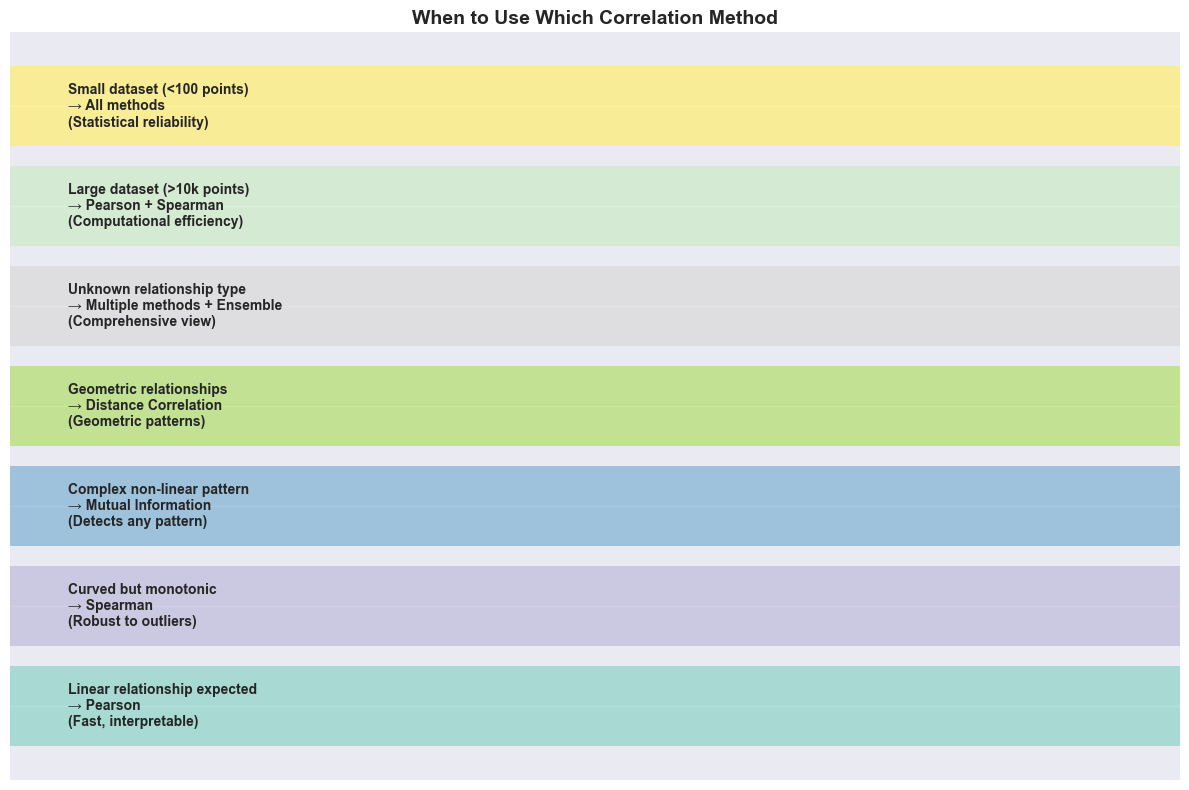


⚠️  COMMON PITFALLS AND MISCONCEPTIONS


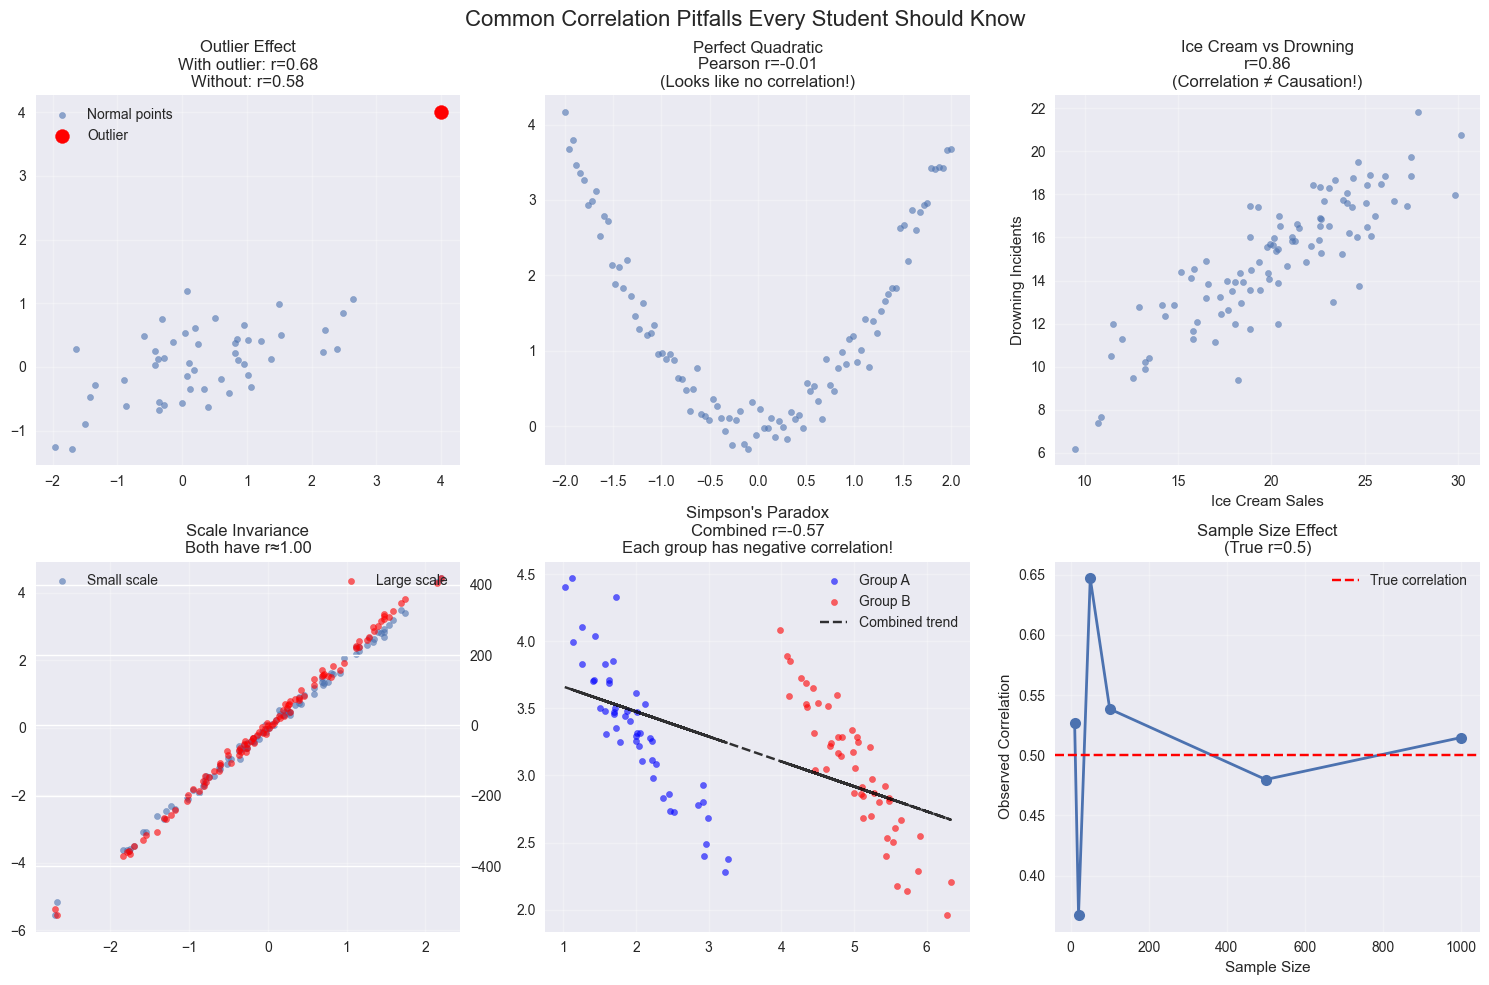


🚨 KEY LESSONS:
1. Outliers can dramatically affect Pearson correlation
2. Zero correlation ≠ no relationship (could be non-linear)
3. High correlation ≠ causation (confounding variables)
4. Pearson is scale-invariant (good thing!)
5. Simpson's Paradox: trends can reverse when groups are combined
6. Small samples give unreliable correlation estimates

🎓 STUDENT EXERCISES

EXERCISE 1: Prediction Challenge
-----------------------------------
Before running the code, predict which correlation method will be highest for each:

Dataset A:
  Pearson: 0.991
  Spearman: 0.991
  Mutual Info: 1.785

Dataset B:
  Pearson: 0.899
  Spearman: 0.945
  Mutual Info: 1.479

Dataset C:
  Pearson: 0.424
  Spearman: 0.397
  Mutual Info: 0.883

Dataset D:
  Pearson: 0.001
  Spearman: 0.005
  Mutual Info: 0.196


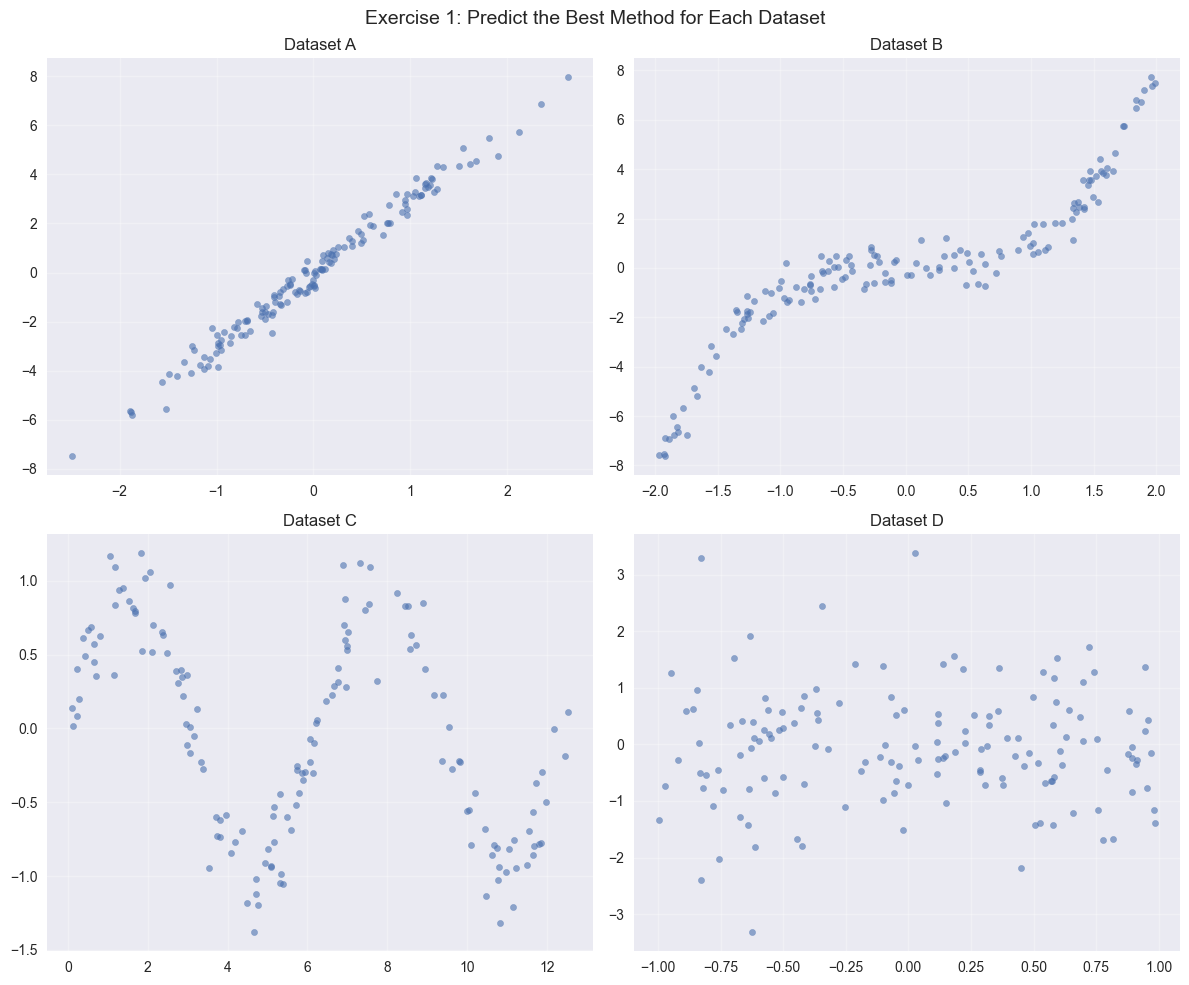


EXERCISE 2: Method Sensitivity Analysis
----------------------------------------
How do different noise levels affect each method?


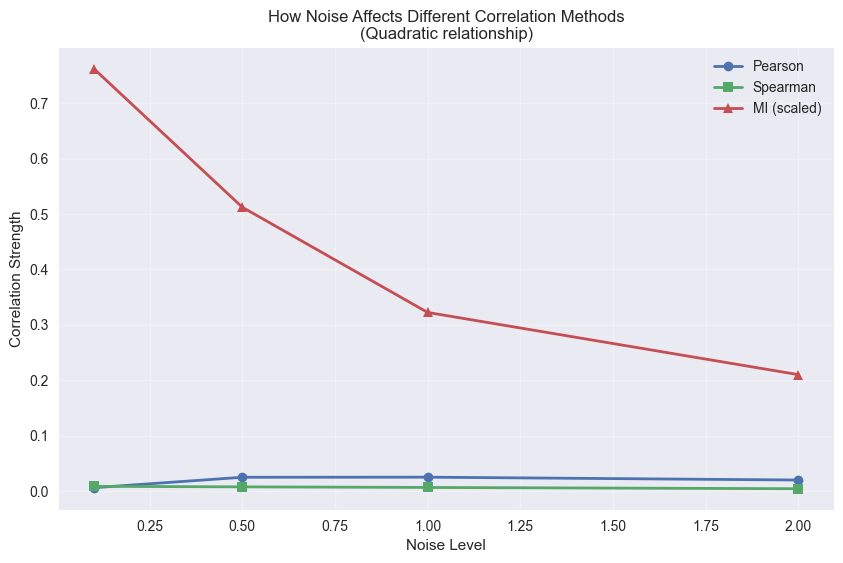


EXERCISE 3: Real-world Application
-----------------------------------
Apply these methods to understand relationships in simulated real data


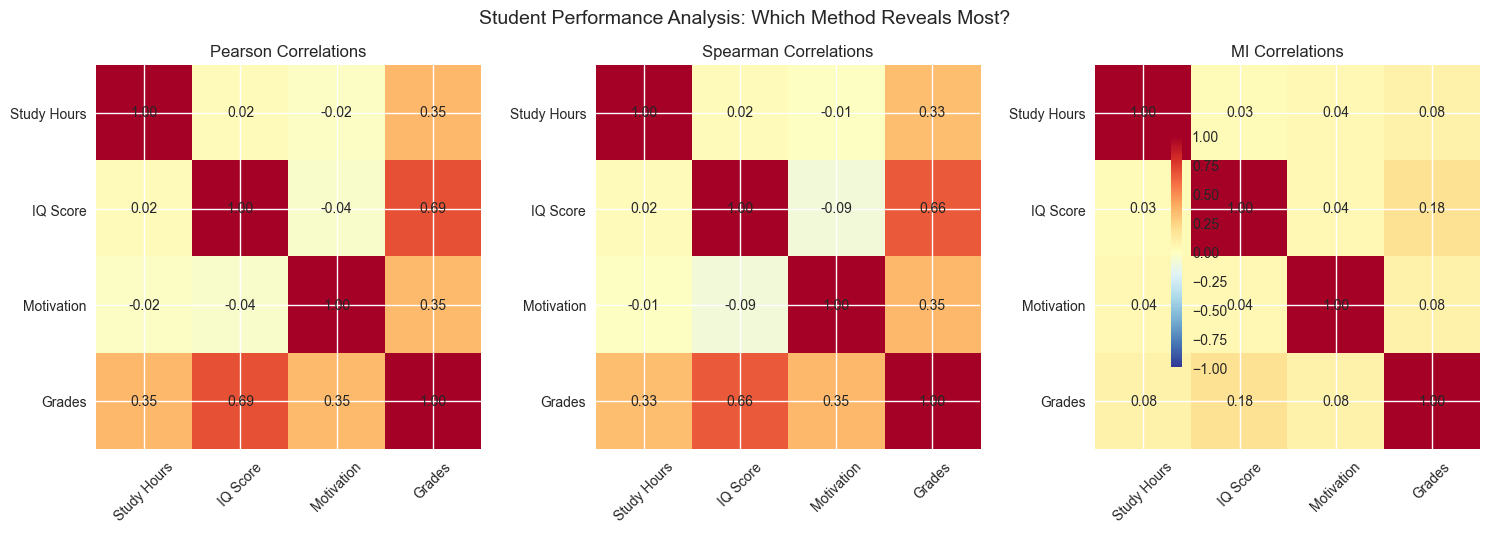

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import rankdata
from scipy.spatial.distance import pdist, squareform
import seaborn as sns
from sklearn.metrics import mutual_info_score
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('seaborn-v0_8')
np.random.seed(42)

# =============================================================================
# UTILITY FUNCTIONS
# =============================================================================

def generate_test_data():
    """Generate various types of relationships for testing correlation methods"""
    n = 200
    x = np.linspace(-3, 3, n)
    
    datasets = {
        'linear_positive': (x, 2*x + np.random.normal(0, 0.5, n)),
        'linear_negative': (x, -1.5*x + np.random.normal(0, 0.5, n)),
        'quadratic': (x, x**2 + np.random.normal(0, 0.5, n)),
        'sine_wave': (x, np.sin(2*x) + np.random.normal(0, 0.3, n)),
        'exponential': (x[x >= 0], np.exp(x[x >= 0]/2) + np.random.normal(0, 0.1, len(x[x >= 0]))),
        'circle': (np.cos(x), np.sin(x) + np.random.normal(0, 0.1, n)),
        'v_shape': (x, np.abs(x) + np.random.normal(0, 0.2, n)),
        'step_function': (x, np.where(x > 0, 1, -1) + np.random.normal(0, 0.1, n)),
        'no_correlation': (np.random.normal(0, 1, n), np.random.normal(0, 1, n))
    }
    
    return datasets

def plot_scatter(x, y, title, correlation_value=None, method_name=""):
    """Create a nice scatter plot with correlation info"""
    plt.figure(figsize=(8, 6))
    plt.scatter(x, y, alpha=0.6, s=30)
    plt.xlabel('X')
    plt.ylabel('Y')
    if correlation_value is not None:
        plt.title(f'{title}\n{method_name} Correlation: {correlation_value:.3f}')
    else:
        plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

# =============================================================================
# 1. PEARSON CORRELATION - The Straight Line Detective
# =============================================================================

def pearson_correlation_from_scratch(x, y):
    """
    Compute Pearson correlation from scratch
    
    Intuition: How well do the points follow a straight line?
    Formula: r = Cov(X,Y) / (std(X) * std(Y))
    """
    # Remove any NaN values
    mask = ~(np.isnan(x) | np.isnan(y))
    x, y = x[mask], y[mask]
    
    # Step 1: Calculate means
    mean_x = np.mean(x)
    mean_y = np.mean(y)
    
    # Step 2: Calculate deviations from mean
    x_dev = x - mean_x
    y_dev = y - mean_y
    
    # Step 3: Calculate covariance (how much they vary together)
    covariance = np.sum(x_dev * y_dev) / (len(x) - 1)
    
    # Step 4: Calculate standard deviations
    std_x = np.sqrt(np.sum(x_dev**2) / (len(x) - 1))
    std_y = np.sqrt(np.sum(y_dev**2) / (len(y) - 1))
    
    # Step 5: Pearson correlation = standardized covariance
    if std_x == 0 or std_y == 0:
        return 0  # No variation in one variable
    
    correlation = covariance / (std_x * std_y)
    
    return correlation

def demonstrate_pearson():
    """Demonstrate Pearson correlation on different datasets"""
    datasets = generate_test_data()
    
    fig, axes = plt.subplots(3, 3, figsize=(15, 12))
    fig.suptitle('Pearson Correlation: How Well Does It Detect Different Relationships?', fontsize=16)
    
    for idx, (name, (x, y)) in enumerate(datasets.items()):
        row, col = idx // 3, idx % 3
        ax = axes[row, col]
        
        # Calculate Pearson correlation
        r = pearson_correlation_from_scratch(x, y)
        
        # Plot
        ax.scatter(x, y, alpha=0.6, s=20)
        ax.set_title(f'{name.replace("_", " ").title()}\nPearson r = {r:.3f}')
        ax.grid(True, alpha=0.3)
        
        # Add trend line for linear relationships
        if 'linear' in name:
            z = np.polyfit(x, y, 1)
            p = np.poly1d(z)
            ax.plot(x, p(x), "r--", alpha=0.8, linewidth=2)
    
    plt.tight_layout()
    plt.show()

# =============================================================================
# 2. SPEARMAN CORRELATION - The Ranking Detective
# =============================================================================

def spearman_correlation_from_scratch(x, y):
    """
    Compute Spearman correlation from scratch
    
    Intuition: Convert to ranks first, then compute Pearson on ranks
    This captures monotonic (consistently increasing/decreasing) relationships
    """
    # Remove any NaN values
    mask = ~(np.isnan(x) | np.isnan(y))
    x, y = x[mask], y[mask]
    
    # Step 1: Convert to ranks (1 = smallest, n = largest)
    ranks_x = rankdata(x)
    ranks_y = rankdata(y)
    
    # Step 2: Apply Pearson correlation to the ranks
    rho = pearson_correlation_from_scratch(ranks_x, ranks_y)
    
    return rho

def demonstrate_spearman():
    """Show how Spearman captures non-linear but monotonic relationships"""
    
    # Create some test cases where Spearman > Pearson
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    # Test case 1: Exponential relationship
    x1 = np.linspace(0, 3, 100)
    y1 = np.exp(x1) + np.random.normal(0, 0.5, 100)
    
    # Test case 2: Power relationship  
    x2 = np.linspace(1, 5, 100)
    y2 = x2**3 + np.random.normal(0, 5, 100)
    
    # Test case 3: Logarithmic relationship
    x3 = np.linspace(1, 50, 100)
    y3 = np.log(x3) + np.random.normal(0, 0.2, 100)
    
    datasets = [
        (x1, y1, "Exponential: y = exp(x)"),
        (x2, y2, "Cubic: y = x³"), 
        (x3, y3, "Logarithmic: y = log(x)")
    ]
    
    for idx, (x, y, title) in enumerate(datasets):
        # Original data
        axes[0, idx].scatter(x, y, alpha=0.6, s=20)
        axes[0, idx].set_title(f'{title}\nPearson: {pearson_correlation_from_scratch(x, y):.3f}')
        axes[0, idx].grid(True, alpha=0.3)
        
        # Rank-transformed data
        ranks_x = rankdata(x)
        ranks_y = rankdata(y)
        axes[1, idx].scatter(ranks_x, ranks_y, alpha=0.6, s=20, color='orange')
        axes[1, idx].set_title(f'Rank-transformed\nSpearman: {spearman_correlation_from_scratch(x, y):.3f}')
        axes[1, idx].set_xlabel('Rank of X')
        axes[1, idx].set_ylabel('Rank of Y')
        axes[1, idx].grid(True, alpha=0.3)
    
    plt.suptitle('Spearman vs Pearson: Why Ranks Matter', fontsize=16)
    plt.tight_layout()
    plt.show()

# =============================================================================
# 3. MUTUAL INFORMATION - The Information Detective
# =============================================================================

def mutual_information_from_scratch(x, y, bins=10):
    """
    Compute mutual information using histogram method
    
    Intuition: How much information does knowing X give us about Y?
    I(X;Y) = H(X) + H(Y) - H(X,Y)
    """
    # Remove any NaN values
    mask = ~(np.isnan(x) | np.isnan(y))
    x, y = x[mask], y[mask]
    
    # Step 1: Discretize the continuous variables into bins
    x_binned = np.digitize(x, np.linspace(x.min(), x.max(), bins))
    y_binned = np.digitize(y, np.linspace(y.min(), y.max(), bins))
    
    # Step 2: Create joint histogram
    joint_hist, _, _ = np.histogram2d(x_binned, y_binned, bins=bins)
    joint_prob = joint_hist / joint_hist.sum()
    
    # Step 3: Calculate marginal probabilities
    prob_x = joint_prob.sum(axis=1)
    prob_y = joint_prob.sum(axis=0)
    
    # Step 4: Calculate mutual information
    mi = 0
    for i in range(bins):
        for j in range(bins):
            if joint_prob[i, j] > 0:  # Avoid log(0)
                mi += joint_prob[i, j] * np.log2(joint_prob[i, j] / (prob_x[i] * prob_y[j]))
    
    return mi

def entropy(probabilities):
    """Calculate entropy: H = -sum(p * log(p))"""
    p = probabilities[probabilities > 0]  # Remove zeros to avoid log(0)
    return -np.sum(p * np.log2(p))

def demonstrate_mutual_information():
    """Show how MI captures complex relationships that linear methods miss"""
    
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    
    # Create test datasets
    n = 500
    
    # 1. Linear relationship
    x1 = np.random.normal(0, 1, n)
    y1 = 2*x1 + np.random.normal(0, 0.5, n)
    
    # 2. Quadratic relationship  
    x2 = np.random.normal(0, 1, n)
    y2 = x2**2 + np.random.normal(0, 0.5, n)
    
    # 3. Sine wave relationship
    x3 = np.random.uniform(-np.pi, np.pi, n)
    y3 = np.sin(x3) + np.random.normal(0, 0.3, n)
    
    # 4. Circle relationship
    theta = np.random.uniform(0, 2*np.pi, n)
    x4 = np.cos(theta) + np.random.normal(0, 0.1, n)
    y4 = np.sin(theta) + np.random.normal(0, 0.1, n)
    
    datasets = [
        (x1, y1, "Linear"),
        (x2, y2, "Quadratic"), 
        (x3, y3, "Sine Wave"),
        (x4, y4, "Circle")
    ]
    
    for idx, (x, y, name) in enumerate(datasets):
        # Scatter plot
        axes[0, idx].scatter(x, y, alpha=0.6, s=15)
        axes[0, idx].set_title(f'{name}')
        axes[0, idx].grid(True, alpha=0.3)
        
        # Calculate correlations
        pearson_r = pearson_correlation_from_scratch(x, y)
        spearman_r = spearman_correlation_from_scratch(x, y)
        mi = mutual_information_from_scratch(x, y, bins=8)
        
        # Bar plot comparing methods
        methods = ['Pearson', 'Spearman', 'MI (scaled)']
        values = [abs(pearson_r), abs(spearman_r), mi/2]  # Scale MI for comparison
        
        bars = axes[1, idx].bar(methods, values, color=['blue', 'orange', 'green'])
        axes[1, idx].set_title(f'Correlation Strength\n{name}')
        axes[1, idx].set_ylabel('Absolute Correlation')
        axes[1, idx].set_ylim(0, 1)
        
        # Add values on bars
        for bar, val in zip(bars, values):
            axes[1, idx].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                             f'{val:.2f}', ha='center', va='bottom', fontsize=9)
    
    plt.suptitle('Mutual Information: Detecting Complex Relationships', fontsize=16)
    plt.tight_layout()
    plt.show()

# =============================================================================
# 4. DISTANCE CORRELATION - The Geometric Detective
# =============================================================================

def distance_correlation_from_scratch(x, y):
    """
    Compute distance correlation from scratch
    
    Intuition: Based on distances between points rather than their values
    Can detect any functional relationship (not just monotonic)
    """
    # Remove any NaN values
    mask = ~(np.isnan(x) | np.isnan(y))
    x, y = x[mask], y[mask]
    n = len(x)
    
    if n < 2:
        return 0
    
    # Step 1: Compute distance matrices
    # Distance matrix for X
    x_dist = np.abs(x[:, np.newaxis] - x[np.newaxis, :])
    # Distance matrix for Y  
    y_dist = np.abs(y[:, np.newaxis] - y[np.newaxis, :])
    
    # Step 2: Center the distance matrices
    # Row means
    x_row_means = np.mean(x_dist, axis=1)
    y_row_means = np.mean(y_dist, axis=1)
    # Overall means
    x_mean = np.mean(x_dist)
    y_mean = np.mean(y_dist)
    
    # Centered matrices
    x_centered = x_dist - x_row_means[:, np.newaxis] - x_row_means[np.newaxis, :] + x_mean
    y_centered = y_dist - y_row_means[:, np.newaxis] - y_row_means[np.newaxis, :] + y_mean
    
    # Step 3: Calculate distance covariance and variances
    dcov_xy = np.sqrt(np.mean(x_centered * y_centered))
    dvar_x = np.sqrt(np.mean(x_centered * x_centered))
    dvar_y = np.sqrt(np.mean(y_centered * y_centered))
    
    # Step 4: Distance correlation
    if dvar_x == 0 or dvar_y == 0:
        return 0
    
    dcor = dcov_xy / np.sqrt(dvar_x * dvar_y)
    
    return dcor

def demonstrate_distance_correlation():
    """Show how distance correlation captures relationships others miss"""
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    n = 200
    
    # 1. Circle relationship (perfect dependence, zero linear correlation)
    theta = np.linspace(0, 2*np.pi, n)
    x1 = np.cos(theta) + np.random.normal(0, 0.1, n)
    y1 = np.sin(theta) + np.random.normal(0, 0.1, n)
    
    # 2. Diamond/square relationship
    x2 = np.random.uniform(-1, 1, n)
    y2 = np.random.choice([-1, 1], n) * (1 - np.abs(x2)) + np.random.normal(0, 0.05, n)
    
    # 3. Spiral relationship
    t = np.linspace(0, 4*np.pi, n)
    x3 = t * np.cos(t) / 10 + np.random.normal(0, 0.1, n)
    y3 = t * np.sin(t) / 10 + np.random.normal(0, 0.1, n)
    
    datasets = [
        (x1, y1, "Circle"),
        (x2, y2, "Diamond"),
        (x3, y3, "Spiral")
    ]
    
    for idx, (x, y, name) in enumerate(datasets):
        # Scatter plot
        axes[0, idx].scatter(x, y, alpha=0.6, s=20)
        axes[0, idx].set_title(f'{name} Relationship')
        axes[0, idx].grid(True, alpha=0.3)
        axes[0, idx].axis('equal')
        
        # Calculate different correlations
        pearson_r = abs(pearson_correlation_from_scratch(x, y))
        spearman_r = abs(spearman_correlation_from_scratch(x, y))
        dcor = distance_correlation_from_scratch(x, y)
        
        # Bar plot
        methods = ['Pearson', 'Spearman', 'Distance']
        values = [pearson_r, spearman_r, dcor]
        
        bars = axes[1, idx].bar(methods, values, color=['blue', 'orange', 'red'])
        axes[1, idx].set_title(f'Correlation Comparison\n{name}')
        axes[1, idx].set_ylabel('Correlation Strength')
        axes[1, idx].set_ylim(0, 1)
        
        # Add values on bars
        for bar, val in zip(bars, values):
            axes[1, idx].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                             f'{val:.3f}', ha='center', va='bottom', fontsize=10)
    
    plt.suptitle('Distance Correlation: Detecting Geometric Relationships', fontsize=16)
    plt.tight_layout()
    plt.show()

# =============================================================================
# 5. HSIC - The Kernel Similarity Detective
# =============================================================================

def rbf_kernel(x, y, sigma=1.0):
    """
    Radial Basis Function (Gaussian) kernel
    k(x,y) = exp(-||x-y||²/(2σ²))
    
    Intuition: How similar are two points? 
    - If identical: similarity = 1
    - If far apart: similarity ≈ 0
    """
    return np.exp(-np.sum((x - y)**2) / (2 * sigma**2))

def create_kernel_matrix(X, sigma=1.0):
    """Create kernel matrix K where K[i,j] = k(x_i, x_j)"""
    n = len(X)
    K = np.zeros((n, n))
    
    for i in range(n):
        for j in range(n):
            K[i, j] = rbf_kernel(X[i], X[j], sigma)
    
    return K

def hsic_from_scratch(x, y, sigma_x=1.0, sigma_y=1.0):
    """
    Compute HSIC (Hilbert-Schmidt Independence Criterion) from scratch
    
    Intuition: 
    1. Create similarity matrices for X and Y using kernels
    2. Center these matrices (remove average similarity)
    3. Measure how well the similarity patterns align
    """
    # Remove any NaN values and reshape
    mask = ~(np.isnan(x) | np.isnan(y))
    x, y = x[mask], y[mask]
    n = len(x)
    
    if n < 2:
        return 0
        
    # Reshape for kernel computation
    X = x.reshape(-1, 1)
    Y = y.reshape(-1, 1)
    
    # Step 1: Create kernel matrices
    K = create_kernel_matrix(X, sigma_x)
    L = create_kernel_matrix(Y, sigma_y)
    
    # Step 2: Create centering matrix H = I - (1/n)*ones*ones^T
    ones = np.ones((n, 1))
    H = np.eye(n) - (1/n) * ones @ ones.T
    
    # Step 3: Center the kernel matrices
    K_centered = H @ K @ H
    L_centered = H @ L @ H
    
    # Step 4: Compute HSIC = trace(K_centered * L_centered) / n²
    hsic = np.trace(K_centered @ L_centered) / (n * n)
    
    return hsic

def demonstrate_hsic():
    """Show how HSIC detects complex dependencies through kernel similarities"""
    
    # Create a comprehensive comparison
    fig, axes = plt.subplots(3, 4, figsize=(16, 12))
    
    n = 150
    
    # Dataset 1: Linear
    x1 = np.random.normal(0, 1, n)
    y1 = 2*x1 + np.random.normal(0, 0.5, n)
    
    # Dataset 2: Quadratic
    x2 = np.random.uniform(-2, 2, n)
    y2 = x2**2 + np.random.normal(0, 0.3, n)
    
    # Dataset 3: Sine wave
    x3 = np.random.uniform(-np.pi, np.pi, n)
    y3 = np.sin(x3) + np.random.normal(0, 0.2, n)
    
    # Dataset 4: Complex pattern (XOR-like)
    x4 = np.random.uniform(-1, 1, n)
    y4 = np.sign(x4) * np.random.uniform(0.5, 1, n) + np.random.normal(0, 0.1, n)
    
    datasets = [
        (x1, y1, "Linear"),
        (x2, y2, "Quadratic"),
        (x3, y3, "Sine Wave"), 
        (x4, y4, "XOR-like")
    ]
    
    for idx, (x, y, name) in enumerate(datasets):
        # Row 1: Scatter plots
        axes[0, idx].scatter(x, y, alpha=0.6, s=20)
        axes[0, idx].set_title(f'{name} Relationship')
        axes[0, idx].grid(True, alpha=0.3)
        
        # Row 2: Kernel matrices visualization
        # Subsample for visualization
        if len(x) > 50:
            indices = np.random.choice(len(x), 50, replace=False)
            x_sub, y_sub = x[indices], y[indices]
        else:
            x_sub, y_sub = x, y
            
        K = create_kernel_matrix(x_sub.reshape(-1, 1))
        im = axes[1, idx].imshow(K, cmap='viridis')
        axes[1, idx].set_title(f'Kernel Matrix for X\n{name}')
        plt.colorbar(im, ax=axes[1, idx])
        
        # Row 3: Correlation comparison
        pearson_r = abs(pearson_correlation_from_scratch(x, y))
        spearman_r = abs(spearman_correlation_from_scratch(x, y))
        mi = mutual_information_from_scratch(x, y, bins=6)
        hsic_val = hsic_from_scratch(x, y)
        
        methods = ['Pearson', 'Spearman', 'MI\n(scaled)', 'HSIC\n(scaled)']
        values = [pearson_r, spearman_r, mi/3, hsic_val*50]  # Scale for comparison
        
        bars = axes[2, idx].bar(methods, values, color=['blue', 'orange', 'green', 'red'])
        axes[2, idx].set_title(f'Method Comparison\n{name}')
        axes[2, idx].set_ylabel('Strength')
        axes[2, idx].set_ylim(0, 1)
        
        # Add values on bars
        for bar, val in zip(bars, values):
            axes[2, idx].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                             f'{val:.2f}', ha='center', va='bottom', fontsize=8)
    
    plt.suptitle('HSIC: Kernel-Based Dependence Detection', fontsize=16)
    plt.tight_layout()
    plt.show()

# =============================================================================
# 6. COMPREHENSIVE COMPARISON
# =============================================================================

def comprehensive_comparison():
    """Compare all methods on various relationship types"""
    
    # Generate test datasets
    n = 300
    np.random.seed(42)
    
    # Various relationship types
    datasets = {}
    
    # Linear relationships
    x = np.random.normal(0, 1, n)
    datasets['Strong Linear'] = (x, 2*x + np.random.normal(0, 0.3, n))
    datasets['Weak Linear'] = (x, 0.5*x + np.random.normal(0, 1, n))
    
    # Non-linear monotonic
    x_mono = np.random.uniform(0, 3, n)
    datasets['Exponential'] = (x_mono, np.exp(x_mono/2) + np.random.normal(0, 0.5, n))
    datasets['Logarithmic'] = (x_mono + 0.1, np.log(x_mono + 0.1) + np.random.normal(0, 0.2, n))
    
    # Non-monotonic relationships
    x_nm = np.random.uniform(-2, 2, n)
    datasets['Quadratic'] = (x_nm, x_nm**2 + np.random.normal(0, 0.3, n))
    datasets['Sine Wave'] = (x_nm, np.sin(2*x_nm) + np.random.normal(0, 0.2, n))
    
    # Complex relationships
    theta = np.random.uniform(0, 2*np.pi, n)
    datasets['Circle'] = (np.cos(theta) + np.random.normal(0, 0.1, n), 
                         np.sin(theta) + np.random.normal(0, 0.1, n))
    
    datasets['No Correlation'] = (np.random.normal(0, 1, n), np.random.normal(0, 1, n))
    
    # Compute all correlations
    methods = ['Pearson', 'Spearman', 'Distance', 'Mutual Info', 'HSIC']
    results = {method: [] for method in methods}
    dataset_names = []
    
    for name, (x, y) in datasets.items():
        dataset_names.append(name)
        
        # Compute correlations
        pearson_r = abs(pearson_correlation_from_scratch(x, y))
        spearman_r = abs(spearman_correlation_from_scratch(x, y))
        dcor = distance_correlation_from_scratch(x, y)
        mi = mutual_information_from_scratch(x, y, bins=8)
        hsic_val = hsic_from_scratch(x, y)
        
        results['Pearson'].append(pearson_r)
        results['Spearman'].append(spearman_r)
        results['Distance'].append(dcor)
        results['Mutual Info'].append(mi / 2)  # Scale for comparison
        results['HSIC'].append(hsic_val * 30)    # Scale for comparison
    
    # Create heatmap
    correlation_matrix = np.array([results[method] for method in methods])
    
    plt.figure(figsize=(12, 8))
    sns.heatmap(correlation_matrix, 
                xticklabels=dataset_names,
                yticklabels=methods,
                annot=True, 
                fmt='.2f',
                cmap='YlOrRd',
                cbar_kws={'label': 'Correlation Strength'})
    
    plt.title('Comprehensive Correlation Method Comparison\n(Higher values = Stronger detected relationship)', 
              fontsize=14)
    plt.xlabel('Relationship Type')
    plt.ylabel('Correlation Method')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    # Create individual plots for each dataset
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.flatten()
    
    for idx, (name, (x, y)) in enumerate(datasets.items()):
        if idx < len(axes):
            axes[idx].scatter(x, y, alpha=0.6, s=15)
            axes[idx].set_title(name)
            axes[idx].grid(True, alpha=0.3)
            
            # Add correlation info
            pearson_r = pearson_correlation_from_scratch(x, y)
            spearman_r = spearman_correlation_from_scratch(x, y)
            axes[idx].text(0.05, 0.95, f'Pearson: {pearson_r:.2f}\nSpearman: {spearman_r:.2f}',
                          transform=axes[idx].transAxes, verticalalignment='top',
                          bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.suptitle('Dataset Visualizations', fontsize=16)
    plt.tight_layout()
    plt.show()

# =============================================================================
# MAIN DEMO FUNCTION
# =============================================================================

def run_all_demonstrations():
    """Run all correlation method demonstrations"""
    
    print("🔍 CORRELATION METHODS FROM SCRATCH - EDUCATIONAL DEMO")
    print("="*60)
    
    print("\n1. Pearson Correlation - The Straight Line Detective")
    print("-" * 50)
    print("Shows: How well do points follow a straight line?")
    print("Best for: Linear relationships")
    print("Fails on: Non-linear patterns, even if perfectly predictable")
    demonstrate_pearson()
    
    print("\n2. Spearman Correlation - The Ranking Detective")
    print("-" * 50)
    print("Shows: Do variables increase/decrease together (monotonic)?")
    print("Best for: Any monotonic relationship (curved but consistent direction)")
    print("Magic: Converts to ranks first, then applies Pearson")
    demonstrate_spearman()
    
    print("\n3. Mutual Information - The Information Detective") 
    print("-" * 50)
    print("Shows: How much information does X give about Y?")
    print("Best for: Any relationship where knowing X helps predict Y")
    print("Strength: Detects complex non-linear patterns")
    demonstrate_mutual_information()
    
    print("\n4. Distance Correlation - The Geometric Detective")
    print("-" * 50)
    print("Shows: Are the geometric patterns related?")
    print("Best for: Any functional relationship (including geometric)")
    print("Unique: Based on distances, not values")
    demonstrate_distance_correlation()
    
    print("\n5. HSIC - The Kernel Similarity Detective")
    print("-" * 50)
    print("Shows: Do similarity patterns align between variables?")
    print("Best for: Most general dependence detection")
    print("Magic: Uses kernel functions to measure similarity")
    demonstrate_hsic()
    
    print("\n6. Comprehensive Comparison")
    print("-" * 50)
    print("Compare all methods across different relationship types")
    comprehensive_comparison()
    
    print("\n🎓 EDUCATIONAL TAKEAWAYS:")
    print("="*40)
    print("✓ Pearson: Fast, interpretable, but only sees straight lines")
    print("✓ Spearman: Robust, catches curves, but must be monotonic")  
    print("✓ MI: Powerful, catches complex patterns, but harder to interpret")
    print("✓ Distance: Very general, but computationally expensive")
    print("✓ HSIC: Most powerful, but requires parameter tuning")
    print("\n🚀 Pro tip: Use multiple methods and compare results!")

# =============================================================================
# INTERACTIVE EXAMPLES FOR STUDENTS
# =============================================================================

def create_your_own_relationship():
    """Let students create their own relationships and see correlations"""
    
    print("\n🎨 CREATE YOUR OWN RELATIONSHIP")
    print("="*40)
    
    # Let students experiment with different functions
    x = np.linspace(-3, 3, 200)
    
    # Example relationships students can try
    relationships = {
        'linear': lambda x: 2*x + np.random.normal(0, 0.5, len(x)),
        'quadratic': lambda x: x**2 + np.random.normal(0, 0.5, len(x)),
        'cubic': lambda x: x**3 + np.random.normal(0, 0.5, len(x)),
        'sine': lambda x: np.sin(x) + np.random.normal(0, 0.3, len(x)),
        'exponential': lambda x: np.exp(x/2) + np.random.normal(0, 0.3, len(x)),
        'step': lambda x: np.where(x > 0, 1, 0) + np.random.normal(0, 0.1, len(x)),
        'random': lambda x: np.random.normal(0, 1, len(x))
    }
    
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.flatten()
    
    for idx, (name, func) in enumerate(relationships.items()):
        y = func(x)
        
        axes[idx].scatter(x, y, alpha=0.6, s=10)
        axes[idx].set_title(f'{name.title()} Relationship')
        axes[idx].grid(True, alpha=0.3)
        
        # Calculate all correlations
        pearson_r = pearson_correlation_from_scratch(x, y)
        spearman_r = spearman_correlation_from_scratch(x, y)
        mi = mutual_information_from_scratch(x, y, bins=8)
        
        # Add text with results
        text = f'Pearson: {pearson_r:.2f}\nSpearman: {spearman_r:.2f}\nMI: {mi:.2f}'
        axes[idx].text(0.05, 0.95, text, transform=axes[idx].transAxes, 
                      verticalalignment='top', fontsize=9,
                      bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # Remove empty subplot
    if len(relationships) < len(axes):
        axes[-1].remove()
    
    plt.suptitle('Student Experiment: Different Relationships and Their Correlations', fontsize=14)
    plt.tight_layout()
    plt.show()

def correlation_strength_guide():
    """Visual guide for interpreting correlation strengths"""
    
    print("\n📊 CORRELATION STRENGTH INTERPRETATION GUIDE")
    print("="*50)
    
    # Create datasets with known correlation strengths
    n = 100
    x = np.random.normal(0, 1, n)
    
    strengths = [0.1, 0.3, 0.5, 0.7, 0.9]
    labels = ['Very Weak\n(0.1)', 'Weak\n(0.3)', 'Moderate\n(0.5)', 'Strong\n(0.7)', 'Very Strong\n(0.9)']
    
    fig, axes = plt.subplots(1, 5, figsize=(15, 3))
    
    for idx, (strength, label) in enumerate(zip(strengths, labels)):
        # Create y with specified correlation to x
        noise_level = np.sqrt(1 - strength**2)
        y = strength * x + noise_level * np.random.normal(0, 1, n)
        
        axes[idx].scatter(x, y, alpha=0.6, s=20)
        axes[idx].set_title(label)
        axes[idx].grid(True, alpha=0.3)
        
        # Verify actual correlation
        actual_r = pearson_correlation_from_scratch(x, y)
        axes[idx].text(0.05, 0.95, f'r = {actual_r:.2f}', 
                      transform=axes[idx].transAxes, verticalalignment='top',
                      bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.8))
    
    plt.suptitle('Pearson Correlation Strength Visual Guide', fontsize=14)
    plt.tight_layout()
    plt.show()
    
    # Interpretation table
    print("\n📋 INTERPRETATION TABLE:")
    print("-" * 30)
    print("0.0 - 0.1: Negligible")
    print("0.1 - 0.3: Weak") 
    print("0.3 - 0.5: Moderate")
    print("0.5 - 0.7: Strong")
    print("0.7 - 0.9: Very Strong")
    print("0.9 - 1.0: Nearly Perfect")

def method_selection_guide():
    """Guide students on when to use which method"""
    
    print("\n🎯 METHOD SELECTION GUIDE")
    print("="*30)
    
    # Create decision tree visualization
    scenarios = [
        ("Linear relationship expected", "Pearson", "Fast, interpretable"),
        ("Curved but monotonic", "Spearman", "Robust to outliers"),
        ("Complex non-linear pattern", "Mutual Information", "Detects any pattern"),
        ("Geometric relationships", "Distance Correlation", "Geometric patterns"),
        ("Unknown relationship type", "Multiple methods + Ensemble", "Comprehensive view"),
        ("Large dataset (>10k points)", "Pearson + Spearman", "Computational efficiency"),
        ("Small dataset (<100 points)", "All methods", "Statistical reliability")
    ]
    
    fig, ax = plt.subplots(figsize=(12, 8))
    
    y_positions = range(len(scenarios))
    colors = plt.cm.Set3(np.linspace(0, 1, len(scenarios)))
    
    for i, (scenario, method, reason) in enumerate(scenarios):
        ax.barh(i, 1, color=colors[i], alpha=0.7)
        ax.text(0.05, i, f"{scenario}\n→ {method}\n({reason})", 
                va='center', ha='left', fontweight='bold', fontsize=10)
    
    ax.set_yticks(y_positions)
    ax.set_yticklabels([])
    ax.set_xlim(0, 1)
    ax.set_xlabel('')
    ax.set_title('When to Use Which Correlation Method', fontsize=14, fontweight='bold')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.set_xticks([])
    
    plt.tight_layout()
    plt.show()

def common_pitfalls_demo():
    """Demonstrate common mistakes students make with correlation"""
    
    print("\n⚠️  COMMON PITFALLS AND MISCONCEPTIONS")
    print("="*45)
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    # Pitfall 1: Outliers affecting Pearson
    n = 50
    x1 = np.random.normal(0, 1, n)
    y1 = 0.3*x1 + np.random.normal(0, 0.5, n)
    # Add outlier
    x1 = np.append(x1, 4)
    y1 = np.append(y1, 4)
    
    axes[0,0].scatter(x1[:-1], y1[:-1], alpha=0.6, s=20, label='Normal points')
    axes[0,0].scatter(x1[-1], y1[-1], color='red', s=100, label='Outlier')
    axes[0,0].set_title(f'Outlier Effect\nWith outlier: r={pearson_correlation_from_scratch(x1, y1):.2f}\nWithout: r={pearson_correlation_from_scratch(x1[:-1], y1[:-1]):.2f}')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)
    
    # Pitfall 2: Non-linear relationship with zero Pearson
    x2 = np.linspace(-2, 2, 100)
    y2 = x2**2 + np.random.normal(0, 0.2, 100)
    
    axes[0,1].scatter(x2, y2, alpha=0.6, s=20)
    axes[0,1].set_title(f'Perfect Quadratic\nPearson r={pearson_correlation_from_scratch(x2, y2):.2f}\n(Looks like no correlation!)')
    axes[0,1].grid(True, alpha=0.3)
    
    # Pitfall 3: Correlation ≠ Causation
    n = 100
    temp = np.random.normal(25, 5, n)  # Temperature
    ice_cream = 0.8 * temp + np.random.normal(0, 2, n)  # Ice cream sales
    drowning = 0.6 * temp + np.random.normal(0, 1, n)   # Drowning incidents
    
    axes[0,2].scatter(ice_cream, drowning, alpha=0.6, s=20)
    axes[0,2].set_title(f'Ice Cream vs Drowning\nr={pearson_correlation_from_scratch(ice_cream, drowning):.2f}\n(Correlation ≠ Causation!)')
    axes[0,2].set_xlabel('Ice Cream Sales')
    axes[0,2].set_ylabel('Drowning Incidents')
    axes[0,2].grid(True, alpha=0.3)
    
    # Pitfall 4: Scale matters for some methods
    x4 = np.random.normal(0, 1, 100)
    y4_small = 2*x4 + np.random.normal(0, 0.1, 100)
    y4_large = 200*x4 + np.random.normal(0, 10, 100)
    
    axes[1,0].scatter(x4, y4_small, alpha=0.6, s=20, label='Small scale')
    ax_twin = axes[1,0].twinx()
    ax_twin.scatter(x4, y4_large, alpha=0.6, s=20, color='red', label='Large scale')
    axes[1,0].set_title(f'Scale Invariance\nBoth have r≈{pearson_correlation_from_scratch(x4, y4_small):.2f}')
    axes[1,0].legend(loc='upper left')
    ax_twin.legend(loc='upper right')
    axes[1,0].grid(True, alpha=0.3)
    
    # Pitfall 5: Simpson's Paradox
    # Two groups with different patterns
    n_group = 50
    x5a = np.random.normal(2, 0.5, n_group)
    y5a = -0.8*x5a + 5 + np.random.normal(0, 0.2, n_group)
    x5b = np.random.normal(5, 0.5, n_group) 
    y5b = -0.8*x5b + 7 + np.random.normal(0, 0.2, n_group)
    
    x5_all = np.concatenate([x5a, x5b])
    y5_all = np.concatenate([y5a, y5b])
    
    axes[1,1].scatter(x5a, y5a, alpha=0.6, s=20, label='Group A', color='blue')
    axes[1,1].scatter(x5b, y5b, alpha=0.6, s=20, label='Group B', color='red')
    
    # Add trend lines
    z_all = np.polyfit(x5_all, y5_all, 1)
    p_all = np.poly1d(z_all)
    axes[1,1].plot(x5_all, p_all(x5_all), "k--", alpha=0.8, label='Combined trend')
    
    axes[1,1].set_title(f"Simpson's Paradox\nCombined r={pearson_correlation_from_scratch(x5_all, y5_all):.2f}\nEach group has negative correlation!")
    axes[1,1].legend()
    axes[1,1].grid(True, alpha=0.3)
    
    # Pitfall 6: Sample size effects
    correlations_by_size = []
    sample_sizes = [10, 20, 50, 100, 500, 1000]
    
    for size in sample_sizes:
        x6 = np.random.normal(0, 1, size)
        y6 = 0.5*x6 + np.random.normal(0, 0.8, size)
        r = pearson_correlation_from_scratch(x6, y6)
        correlations_by_size.append(r)
    
    axes[1,2].plot(sample_sizes, correlations_by_size, 'o-', linewidth=2, markersize=8)
    axes[1,2].axhline(y=0.5, color='red', linestyle='--', label='True correlation')
    axes[1,2].set_xlabel('Sample Size')
    axes[1,2].set_ylabel('Observed Correlation')
    axes[1,2].set_title('Sample Size Effect\n(True r=0.5)')
    axes[1,2].legend()
    axes[1,2].grid(True, alpha=0.3)
    
    plt.suptitle('Common Correlation Pitfalls Every Student Should Know', fontsize=16)
    plt.tight_layout()
    plt.show()
    
    print("\n🚨 KEY LESSONS:")
    print("1. Outliers can dramatically affect Pearson correlation")
    print("2. Zero correlation ≠ no relationship (could be non-linear)")
    print("3. High correlation ≠ causation (confounding variables)")
    print("4. Pearson is scale-invariant (good thing!)")
    print("5. Simpson's Paradox: trends can reverse when groups are combined")
    print("6. Small samples give unreliable correlation estimates")

# =============================================================================
# EDUCATIONAL EXERCISES
# =============================================================================

def student_exercises():
    """Provide hands-on exercises for students"""
    
    print("\n🎓 STUDENT EXERCISES")
    print("="*25)
    
    print("\nEXERCISE 1: Prediction Challenge")
    print("-" * 35)
    print("Before running the code, predict which correlation method will be highest for each:")
    
    # Create exercise datasets
    n = 150
    
    exercises = {
        'A': (np.random.normal(0, 1, n), lambda x: 3*x + np.random.normal(0, 0.4, n)),
        'B': (np.random.uniform(-2, 2, n), lambda x: x**3 + np.random.normal(0, 0.5, n)),
        'C': (np.random.uniform(0, 4*np.pi, n), lambda x: np.sin(x) + np.random.normal(0, 0.2, n)),
        'D': (np.random.uniform(-1, 1, n), lambda x: np.random.normal(0, 1, len(x))),
    }
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.flatten()
    
    for idx, (label, (x, y_func)) in enumerate(exercises.items()):
        y = y_func(x)
        
        axes[idx].scatter(x, y, alpha=0.6, s=20)
        axes[idx].set_title(f'Dataset {label}')
        axes[idx].grid(True, alpha=0.3)
        
        # Calculate correlations
        pearson_r = abs(pearson_correlation_from_scratch(x, y))
        spearman_r = abs(spearman_correlation_from_scratch(x, y))
        mi = mutual_information_from_scratch(x, y, bins=8)
        
        print(f"\nDataset {label}:")
        print(f"  Pearson: {pearson_r:.3f}")
        print(f"  Spearman: {spearman_r:.3f}")
        print(f"  Mutual Info: {mi:.3f}")
    
    plt.suptitle('Exercise 1: Predict the Best Method for Each Dataset', fontsize=14)
    plt.tight_layout()
    plt.show()
    
    print("\nEXERCISE 2: Method Sensitivity Analysis")
    print("-" * 40)
    print("How do different noise levels affect each method?")
    
    # Test with increasing noise
    x = np.linspace(-2, 2, 100)
    noise_levels = [0.1, 0.5, 1.0, 2.0]
    
    pearson_results = []
    spearman_results = []
    mi_results = []
    
    for noise in noise_levels:
        y = x**2 + np.random.normal(0, noise, len(x))
        
        pearson_results.append(abs(pearson_correlation_from_scratch(x, y)))
        spearman_results.append(abs(spearman_correlation_from_scratch(x, y)))
        mi_results.append(mutual_information_from_scratch(x, y, bins=8))
    
    plt.figure(figsize=(10, 6))
    plt.plot(noise_levels, pearson_results, 'o-', label='Pearson', linewidth=2)
    plt.plot(noise_levels, spearman_results, 's-', label='Spearman', linewidth=2)
    plt.plot(noise_levels, [mi/2 for mi in mi_results], '^-', label='MI (scaled)', linewidth=2)
    
    plt.xlabel('Noise Level')
    plt.ylabel('Correlation Strength')
    plt.title('How Noise Affects Different Correlation Methods\n(Quadratic relationship)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    print("\nEXERCISE 3: Real-world Application")
    print("-" * 35)
    print("Apply these methods to understand relationships in simulated real data")
    
    # Simulate realistic data
    np.random.seed(123)
    n = 200
    
    # Student data simulation
    study_hours = np.random.exponential(2, n)  # Right-skewed distribution
    iq_score = np.random.normal(100, 15, n)
    motivation = np.random.uniform(1, 10, n)
    
    # Complex relationship: grades depend on all factors non-linearly
    grades = (
        0.3 * np.log(study_hours + 1) * 20 +  # Diminishing returns from study
        0.4 * (iq_score - 100) / 15 * 20 +    # IQ effect
        0.3 * motivation * 5 +                # Motivation effect
        np.random.normal(0, 5, n)             # Random noise
    )
    grades = np.clip(grades, 0, 100)  # Keep in 0-100 range
    
    variables = {
        'Study Hours': study_hours,
        'IQ Score': iq_score, 
        'Motivation': motivation,
        'Grades': grades
    }
    
    # Create correlation matrix using different methods
    var_names = list(variables.keys())
    n_vars = len(var_names)
    
    methods_comp = ['Pearson', 'Spearman', 'MI']
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    for method_idx, method in enumerate(methods_comp):
        corr_matrix = np.eye(n_vars)
        
        for i in range(n_vars):
            for j in range(i+1, n_vars):
                x = variables[var_names[i]]
                y = variables[var_names[j]]
                
                if method == 'Pearson':
                    corr = pearson_correlation_from_scratch(x, y)
                elif method == 'Spearman':
                    corr = spearman_correlation_from_scratch(x, y)
                else:  # MI
                    corr = mutual_information_from_scratch(x, y, bins=6) / 2
                
                corr_matrix[i, j] = corr_matrix[j, i] = corr
        
        im = axes[method_idx].imshow(corr_matrix, cmap='RdYlBu_r', vmin=-1, vmax=1)
        axes[method_idx].set_title(f'{method} Correlations')
        axes[method_idx].set_xticks(range(n_vars))
        axes[method_idx].set_yticks(range(n_vars))
        axes[method_idx].set_xticklabels(var_names, rotation=45)
        axes[method_idx].set_yticklabels(var_names)
        
        # Add correlation values
        for i in range(n_vars):
            for j in range(n_vars):
                axes[method_idx].text(j, i, f'{corr_matrix[i,j]:.2f}',
                                     ha='center', va='center', fontsize=10)
    
    plt.colorbar(im, ax=axes, shrink=0.6)
    plt.suptitle('Student Performance Analysis: Which Method Reveals Most?', fontsize=14)
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    # Run the complete educational demonstration
    run_all_demonstrations()
    
    # Additional educational content
    create_your_own_relationship()
    correlation_strength_guide()
    method_selection_guide()
    common_pitfalls_demo()
    student_exercises()